In [ ]:
!pip install evo-model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 92.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.2 MB/s eta 0:00:00
  C

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pandas as pd
import torch
from torch import nn
from evo import Evo
import pickle
from tqdm import tqdm

# Set device (GPU if available, else CPU)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Load Evo model and tokenizer
evo_model = Evo('evo-1-131k-base')
model, tokenizer = evo_model.model, evo_model.tokenizer
model.to(device)
model.eval()

# Read the provided dataset file (dataset_FINAL.tsv) from the local path
dataset_path = '/content/drive/MyDrive/evORFinder/datasets/dataset_FINAL.tsv'
df = pd.read_csv(dataset_path, sep='\t')
df.dropna(subset=['smorf', 'upstream', 'downstream'], inplace=True)
df_subset = df.sample(n=10000, random_state=42)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

configuration_hyena.py:   0%|          | 0.00/3.13k [00:00<?, ?B/s]

modeling_hyena.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

utils.py:   0%|          | 0.00/2.87k [00:00<?, ?B/s]

layers.py:   0%|          | 0.00/5.39k [00:00<?, ?B/s]

model.py:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

positional_embeddings.py:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

tokenizer.py:   0%|          | 0.00/4.40k [00:00<?, ?B/s]

engine.py:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

cache.py:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

In [ ]:
# Monkey-patch the model's unembed function with an identity mapping
class CustomEmbedding(nn.Module):
    def unembed(self, u):
        return u

model.unembed = CustomEmbedding()

# Helper function to extract Evo embedding for a given DNA sequence.
def get_evo_embedding(sequence):
    # Tokenize the input sequence; tokenizer.tokenize returns a list of token ids.
    input_ids = torch.tensor(tokenizer.tokenize(sequence), dtype=torch.int).to(device).unsqueeze(0)
    with torch.no_grad():
        # The model returns (embedding, extra_outputs). The embedding shape is (batch, seq_length, embed_dim)
        embed, _ = model(input_ids)
    # Aggregate over the sequence positions (mean over token dimension)
    aggregated_embedding = embed.mean(dim=1).squeeze(0)  # shape: (embed_dim,)
    # Cast to float32 and convert to NumPy array.
    return aggregated_embedding.to(torch.float32).cpu().numpy()

# Compute embeddings for each column and add them as new columns in the DataFrame.
tqdm.pandas(desc="Extracting smorf embeddings")
df_subset['embedding_smorf'] = df_subset['smorf'].progress_apply(get_evo_embedding)

tqdm.pandas(desc="Extracting upstream embeddings")
df_subset['embedding_upstream'] = df_subset['upstream'].progress_apply(get_evo_embedding)

tqdm.pandas(desc="Extracting downstream embeddings")
df_subset['embedding_downstream'] = df_subset['downstream'].progress_apply(get_evo_embedding)

tqdm.pandas(desc="Extracting full embeddings")
df_subset['embedding_full'] = df_subset.progress_apply(lambda row: get_evo_embedding(row['upstream'] + row['smorf'] + row['downstream']), axis=1)

# Save the new DataFrame (with all original columns plus the embedding columns) to a pickle file.
df_subset.to_pickle('/content/drive/MyDrive/evORFinder/datasets/datasubset_with_full_embeddings.pkl')
print("DataFrame with embeddings saved to 'datasubset_with_full_embeddings.pkl'.")

Extracting full embeddings: 100%|██████████| 10000/10000 [10:00<00:00, 16.66it/s]


DataFrame with embeddings saved to 'datasubset_with_full_embeddings.pkl'.


In [ ]:
import os
import pandas as pd
import numpy as np

# Load the dataframe
df_subset = pd.read_pickle('/content/drive/MyDrive/evORFinder/datasets/datasubset_with_full_embeddings.pkl')

# Create a new column "full" by concatenating upstream, smorf, and downstream
df_subset['full'] = df_subset['upstream'] + df_subset['smorf'] + df_subset['downstream']

# Set the k-mer length (you can modify this value as needed)
k = 3

# Function to extract all overlapping k-mers from a sequence
def get_kmers(seq, k):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

# Determine the set of unique k-mers from all sequences across the four columns.
unique_kmers = set()
for col in ['smorf', 'upstream', 'downstream', 'full']:
    for seq in df_subset[col]:
        kmers = get_kmers(seq, k)
        unique_kmers.update(kmers)

# Sort the k-mers and create a mapping from k-mer to an index
vocab = sorted(list(unique_kmers))
kmer_to_index = {kmer: idx for idx, kmer in enumerate(vocab)}

# Function to encode a single sequence into a k-mer count vector (bag-of-k-mers)
def kmer_encode(seq, k, kmer_to_index):
    # Create a zero vector of length equal to the total number of unique k-mers
    encoding = np.zeros(len(kmer_to_index), dtype=int)
    kmers = get_kmers(seq, k)
    for kmer in kmers:
        # If the k-mer is in our vocabulary, increment its count
        if kmer in kmer_to_index:
            encoding[kmer_to_index[kmer]] += 1
    return encoding

# Apply k-mer encoding to each desired column and store in new columns
df_subset['kmer_smorf'] = df_subset['smorf'].apply(lambda x: kmer_encode(x, k, kmer_to_index))
df_subset['kmer_upstream'] = df_subset['upstream'].apply(lambda x: kmer_encode(x, k, kmer_to_index))
df_subset['kmer_downstream'] = df_subset['downstream'].apply(lambda x: kmer_encode(x, k, kmer_to_index))
df_subset['kmer_full'] = df_subset['full'].apply(lambda x: kmer_encode(x, k, kmer_to_index))

# Optional: Display an example to verify
print("Example smorf sequence:", df_subset.iloc[0]['smorf'])
print("K-mer encoded shape (smorf):", df_subset.iloc[0]['kmer_smorf'].shape)

# Save the modified DataFrame (with k-mer representations) to a pickle file.
df_subset.to_pickle('/content/drive/MyDrive/evORFinder/datasets/datasubset_with_kmer_and_full_embeddings.pkl')
print("DataFrame with k-mer representations saved to 'datasubset_with_kmer_and_full_embeddings.pkl'.")

Example smorf sequence: ATGTTAAATGACGAAATATGTAAATTAAGAGATAGATTAAACGAAAGTATTACTATAGGGGAAGATTACAATATAATATATAAATTAAGTGTTGAACTTGATGAATTAATAGCAGAATATTATAGAAAGCTTATAAAAGCAAAATAA
K-mer encoded shape (smorf): (125,)
DataFrame with k-mer representations saved to 'datasubset_with_kmer_and_full_embeddings.pkl'.


In [ ]:
df

set         clust                                 name origin  \
60287   train  smorfam02935           SRS144135|31130|129|275|-1   real   
38271   train  smorfam00398  SRS049896|100_4224.208254|61|198|-1   real   
447517    dev        195481         SRS146830|1340|13074|13202|1   fake   
255578  train  smorfam01930    SRS015578|100_386.194237|8|127|-1   fake   
392941  train         70008    SRS055966|100_160.161|2113|2259|1   fake   
...       ...           ...                                  ...    ...   
407760  train        179406          SRS063215|17517|3541|3672|1   fake   
425429    dev  smorfam00492  SRS077018|100_20384.20385|85|222|-1   fake   
260368  train  smorfam00750  SRS144300|100_5706.152117|806|940|1   fake   
399343  train        291253             SRS893350|6674|188|301|1   fake   
20693   train  smorfam00291              SRS105153|2441|20|160|1   real   

               y                                           upstream  \
60287   positive  GATTAATAAACAAAAAAGAAATAATTCGTTGACTAAAATGTAAAAA...   
38271   positive  AGGACATTTATCGCTTTCAGACCTATCTGGAAGATCACAGCACCAC...   
447517  negative  CGAATAGAATACAATTTTATTATAATGGTAAAGCTGAAAAGCCGAG...   
255578  negative  AATTTTATTAAATGAATTTGTAAATGTGTTTGTTTTATGTCAAATA...   
392941  negative  TAGGGATCACCTCCGGAGGGCAGGTGCGGCTGGAATCTTCTAGATA...   
...          ...                                                ...   
407760  negative  TAATTTATATTTTCTAATGACAAAATGGATTTTTATCCTTAAGAAA...   
425429  negative  GCTCCTGGTGCACAGTCCTATATAAGAATGGTACAAAGTAAGGGCA...   
260368  negative  AAACATTACAAGTGATAGATATAAAGATACAGAGTTTCGATAATAT...   
399343  negative  GTGAGTGTCACCGAGGAAGCGAGGGAACTTCAACGAGAGCTCGTTC...   
20693   positive                                TTAATTAGCATAGAACAGC   

                                               downstream  \
60287   AATGATTCTTTCTGTAATAAAAAAGTAAAAATGTAATTAAAAAGTA...   
38271   AAACACCCTGTCGGTGCTGAAAATTGCACCGGGACAGCATCCGCAG...   
447517  AATGCCTTTAGACCCCAAGTTTTGTACTGACATGTAGATTTTATTA...   
255578                                            CTGGATG   
392941  TAGCACTTATGATCCGATCCAAACAGTGAGAATTCACAAGAAGACT...   
...                                                   ...   
407760  AGCTAGGGAAACATTTACAAGGGAATGGAGGATACAAAAAATTATT...   
425429  ATTGGTTTTATATGACCGAGTCTTTACTCGGCTTTTGTTTTGAAAT...   
260368                         TTGACTTTCCAAAAAGGCTATTCTGA   
399343  AGGTATTGAGTGTTTTGTTATTCGTTTAACAATAATCTTAATGATT...   
20693   TTTATAACAAAAACAGCTTGCTCTGATAATTGTTTGTGAGATAATT...   

                                                    smorf  \
60287   ATGTTAAATGACGAAATATGTAAATTAAGAGATAGATTAAACGAAA...   
38271   ATGCTGAACTTTTTTATCGGTATCGCATTTTTTGAGGCTGGTGCCT...   
447517  ATGACGCTCTTATTTTTCAATGTCCTCCGTATTGCAAGAATTTATT...   
255578  ATGGAAATAGAGTTGAATTGTTGGTCCGGTTATAGTTTAAATTTAA...   
392941  GTGGATTCTGCGATGTCGATGGAGAGAGCCGGGTCGCCCGGGGGGA...   
...                                                   ...   
407760  ATGATTGACTTGTTATTATACTTGAAAAATCCAGAAGATATTAAAG...   
425429  ATGGAAGATCTAACTAAGAAACACTATGACGGCTTTTCTTCTAGCT...   
260368  ATGGAAATGTTTGCCCACTTTGGTAGTAAAAAAAATTCGAAAATTC...   
399343  ATGGTTCATGAGGCTCAAGCGGCTCAGGCTCACGTTATTTCCCGTC...   
20693   ATGAACGACAAGGATGAACTGATAGCTTCCCTTCGGAAACAGCTAC...   

                                          embedding_smorf  \
60287   [0.007598877, -1.03125, 0.006378174, 0.0230712...   
38271   [-0.036621094, -1.0703125, -0.05908203, 0.0270...   
447517  [-0.010314941, -1.046875, -0.05493164, 0.02612...   
255578  [-0.01159668, -1.046875, -0.034423828, 0.02526...   
392941  [-0.050048828, -1.0859375, -0.057373047, 0.028...   
...                                                   ...   
407760  [0.0014572144, -1.0390625, -0.020874023, 0.024...   
425429  [-0.01586914, -1.0546875, -0.029541016, 0.0250...   
260368  [-0.022827148, -1.0625, -0.04638672, 0.0263671...   
399343  [-0.032226562, -1.0703125, -0.060302734, 0.027...   
20693   [-0.03540039, -1.0703125, 0.0048828125, 0.0264...   

                                       embedding_upstream

In [ ]:
import umap.umap_ as umap
import numpy as np
import seaborn as sns

df = pd.read_pickle('/content/drive/MyDrive/evORFinder/datasets/datasubset_with_kmer_and_full_embeddings.pkl')

# Stack embeddings into arrays
upstream_embeds = np.vstack(df['embedding_upstream'].values)
downstream_embeds = np.vstack(df['embedding_downstream'].values)
smorf_embeds = np.vstack(df['embedding_smorf'].values)
full_embeds = np.vstack(df['embedding_full'].values)

combined_embeds = np.hstack([upstream_embeds, downstream_embeds, smorf_embeds])
combined_embeds_w_full = np.hstack([upstream_embeds, downstream_embeds, smorf_embeds, full_embeds])

In [ ]:
# smorf t-SNE
from sklearn.manifold import TSNE

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto', init='random')
smorf_embedding_tsne = tsne.fit_transform(smorf_embeds)

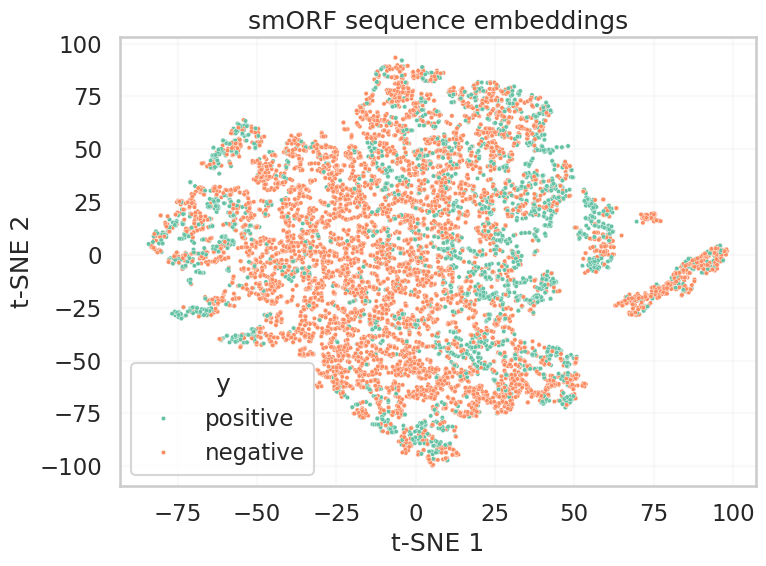

In [164]:
# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=smorf_embedding_tsne[:, 0], y=smorf_embedding_tsne[:, 1],
                hue=df['y'],
                palette='Set2',
                alpha=1,
                s=10, legend=False)  # <-- point size control
plt.title('smORF sequence embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(alpha=0.1)
plt.tight_layout()
plt.savefig("smorf_tsne.svg", format="svg", bbox_inches='tight')
plt.show()

Density overlap between classes: 0.6757


<ipython-input-82-a278482f749e>:37: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
<ipython-input-82-a278482f749e>:38: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')


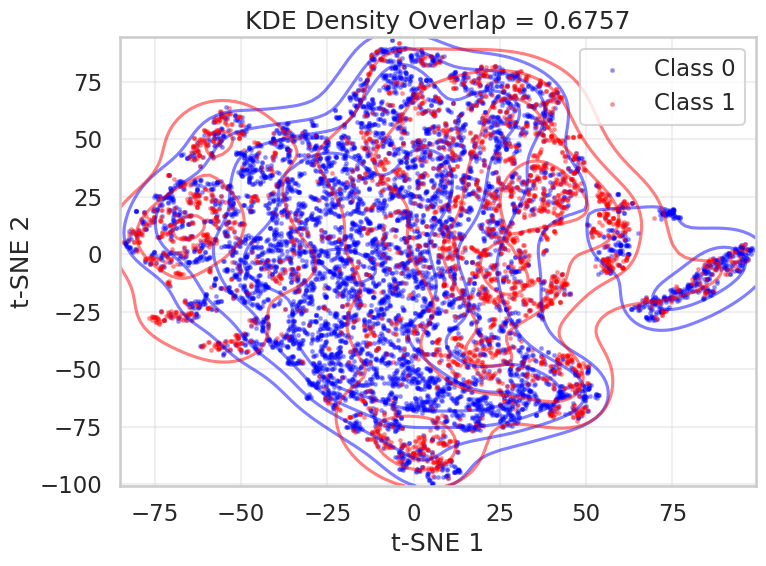

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Prepare data
X = smorf_embedding_tsne
y = df['y'].values

# Split classes
class_0 = X[y == "negative"]
class_1 = X[y == "positive"]

# Create a grid over the data
xmin, ymin = X.min(axis=0) - 1
xmax, ymax = X.max(axis=0) + 1
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Estimate density for each class
kde_class_0 = gaussian_kde(class_0.T)
kde_class_1 = gaussian_kde(class_1.T)

density_0 = kde_class_0(positions)
density_1 = kde_class_1(positions)

# Normalize densities
density_0 /= density_0.sum()
density_1 /= density_1.sum()

# Overlap = sum of the minimum of densities at each point
overlap = np.sum(np.minimum(density_0, density_1))

print(f"Density overlap between classes: {overlap:.4f}")

# Visualize
plt.figure(figsize=(8, 6))
plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', s=5, alpha=0.3, label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', s=5, alpha=0.3, label='Class 1')
plt.title(f'KDE Density Overlap = {overlap:.4f}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Prepare data
X_tsne = smorf_embedding_tsne
labels = df['y'].values  # assuming this is your label column

# Compute silhouette score
score = silhouette_score(X_tsne, labels)

print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0346


In [ ]:
# up t-SNE
from sklearn.manifold import TSNE

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto', init='random')
up_embedding_tsne = tsne.fit_transform(upstream_embeds)

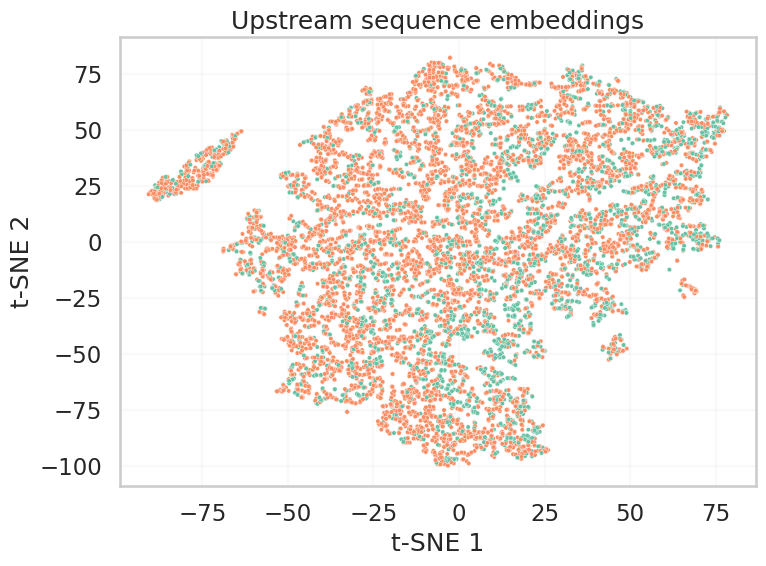

In [ ]:
# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=up_embedding_tsne[:, 0], y=up_embedding_tsne[:, 1],
                hue=df['y'],
                palette='Set2',
                alpha=1,
                s=10, legend=False)  # <-- point size control
plt.title('Upstream sequence embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(alpha=0.1)
plt.tight_layout()
plt.savefig("up_tsne.svg", format="svg", bbox_inches='tight')
plt.show()

Density overlap between classes: 0.8208


<ipython-input-83-20916581cc75>:37: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
<ipython-input-83-20916581cc75>:38: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')


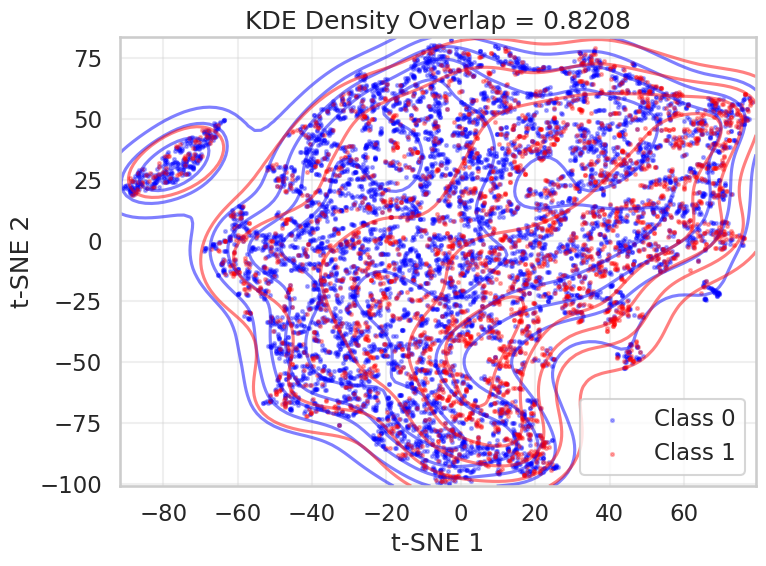

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Prepare data
X = up_embedding_tsne
y = df['y'].values

# Split classes
class_0 = X[y == "negative"]
class_1 = X[y == "positive"]

# Create a grid over the data
xmin, ymin = X.min(axis=0) - 1
xmax, ymax = X.max(axis=0) + 1
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Estimate density for each class
kde_class_0 = gaussian_kde(class_0.T)
kde_class_1 = gaussian_kde(class_1.T)

density_0 = kde_class_0(positions)
density_1 = kde_class_1(positions)

# Normalize densities
density_0 /= density_0.sum()
density_1 /= density_1.sum()

# Overlap = sum of the minimum of densities at each point
overlap = np.sum(np.minimum(density_0, density_1))

print(f"Density overlap between classes: {overlap:.4f}")

# Visualize
plt.figure(figsize=(8, 6))
plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', s=5, alpha=0.3, label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', s=5, alpha=0.3, label='Class 1')
plt.title(f'KDE Density Overlap = {overlap:.4f}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Prepare data
X_tsne = up_embedding_tsne
labels = df['y'].values  # assuming this is your label column

# Compute silhouette score
score = silhouette_score(X_tsne, labels)

print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0107


In [ ]:
# down t-SNE
from sklearn.manifold import TSNE

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto', init='random')
down_embedding_tsne = tsne.fit_transform(downstream_embeds)

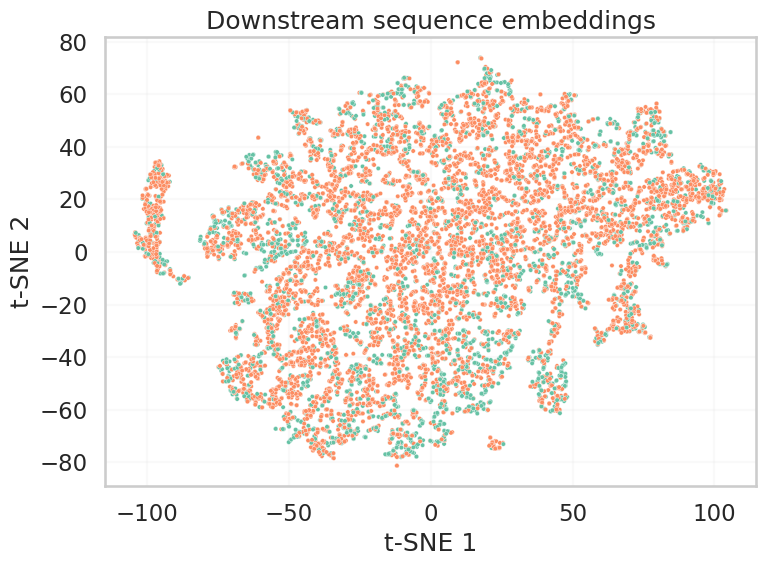

In [ ]:
# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=down_embedding_tsne[:, 0], y=down_embedding_tsne[:, 1],
                hue=df['y'],
                palette='Set2',
                alpha=1,
                s=10, legend=False)  # <-- point size control
plt.title('Downstream sequence embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(alpha=0.1)
plt.tight_layout()
plt.savefig("down_tsne.svg", format="svg", bbox_inches='tight')
plt.show()

Density overlap between classes: 0.8109


<ipython-input-84-60695fd988a0>:37: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
<ipython-input-84-60695fd988a0>:38: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')


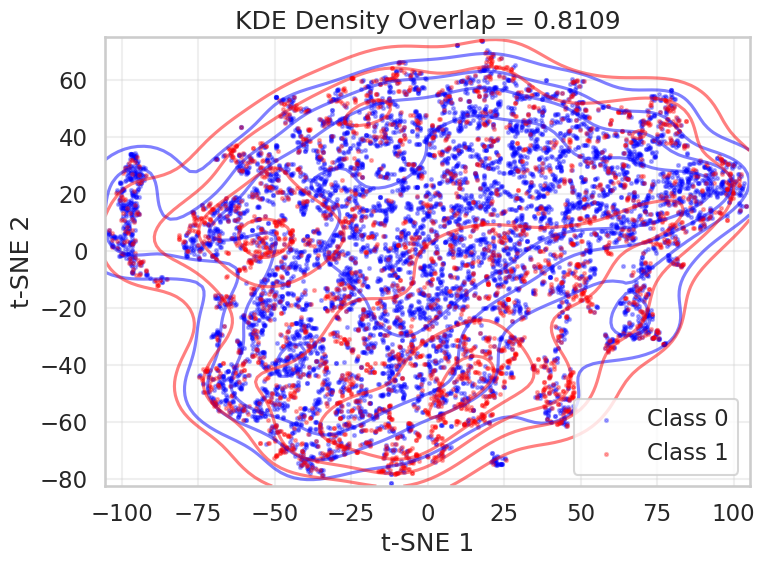

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Prepare data
X = down_embedding_tsne
y = df['y'].values

# Split classes
class_0 = X[y == "negative"]
class_1 = X[y == "positive"]

# Create a grid over the data
xmin, ymin = X.min(axis=0) - 1
xmax, ymax = X.max(axis=0) + 1
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Estimate density for each class
kde_class_0 = gaussian_kde(class_0.T)
kde_class_1 = gaussian_kde(class_1.T)

density_0 = kde_class_0(positions)
density_1 = kde_class_1(positions)

# Normalize densities
density_0 /= density_0.sum()
density_1 /= density_1.sum()

# Overlap = sum of the minimum of densities at each point
overlap = np.sum(np.minimum(density_0, density_1))

print(f"Density overlap between classes: {overlap:.4f}")

# Visualize
plt.figure(figsize=(8, 6))
plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', s=5, alpha=0.3, label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', s=5, alpha=0.3, label='Class 1')
plt.title(f'KDE Density Overlap = {overlap:.4f}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Prepare data
X_tsne = down_embedding_tsne
labels = df['y'].values  # assuming this is your label column

# Compute silhouette score
score = silhouette_score(X_tsne, labels)

print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0194


In [ ]:
# Full t-SNE
from sklearn.manifold import TSNE

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto', init='random')
full_embedding_tsne = tsne.fit_transform(full_embeds)

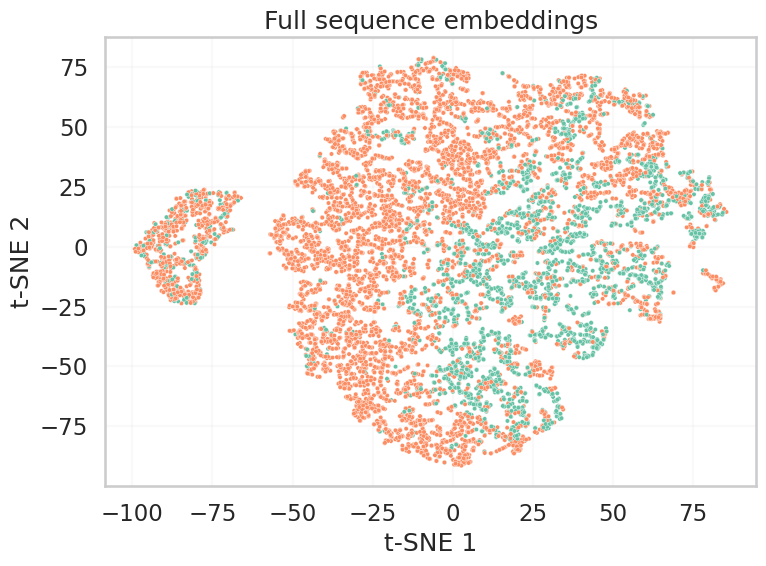

In [ ]:
# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=full_embedding_tsne[:, 0], y=full_embedding_tsne[:, 1],
                hue=df['y'],
                palette='Set2',
                alpha=1,
                s=10, legend=False)  # <-- point size control
plt.title('Full sequence embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(alpha=0.1)
plt.tight_layout()
plt.savefig("full_tsne.svg", format="svg", bbox_inches='tight')
plt.show()

Density overlap between classes: 0.5074


<ipython-input-85-3ea5497fa175>:37: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
<ipython-input-85-3ea5497fa175>:38: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')


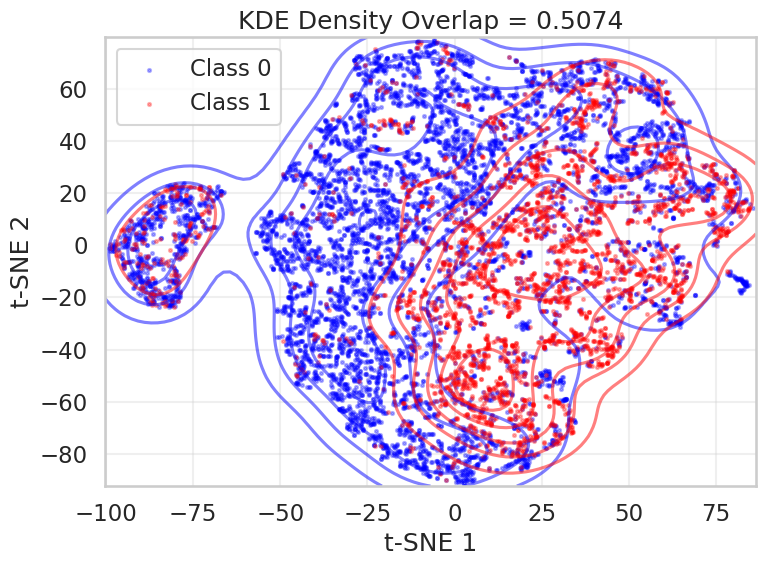

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Prepare data
X = full_embedding_tsne
y = df['y'].values

# Split classes
class_0 = X[y == "negative"]
class_1 = X[y == "positive"]

# Create a grid over the data
xmin, ymin = X.min(axis=0) - 1
xmax, ymax = X.max(axis=0) + 1
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Estimate density for each class
kde_class_0 = gaussian_kde(class_0.T)
kde_class_1 = gaussian_kde(class_1.T)

density_0 = kde_class_0(positions)
density_1 = kde_class_1(positions)

# Normalize densities
density_0 /= density_0.sum()
density_1 /= density_1.sum()

# Overlap = sum of the minimum of densities at each point
overlap = np.sum(np.minimum(density_0, density_1))

print(f"Density overlap between classes: {overlap:.4f}")

# Visualize
plt.figure(figsize=(8, 6))
plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', s=5, alpha=0.3, label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', s=5, alpha=0.3, label='Class 1')
plt.title(f'KDE Density Overlap = {overlap:.4f}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Prepare data
X_tsne = full_embedding_tsne
labels = df['y'].values  # assuming this is your label column

# Compute silhouette score
score = silhouette_score(X_tsne, labels)

print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0587


In [ ]:
# Combined t-SNE no Full
from sklearn.manifold import TSNE

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto', init='random')
comb_embedding_tsne = tsne.fit_transform(combined_embeds)

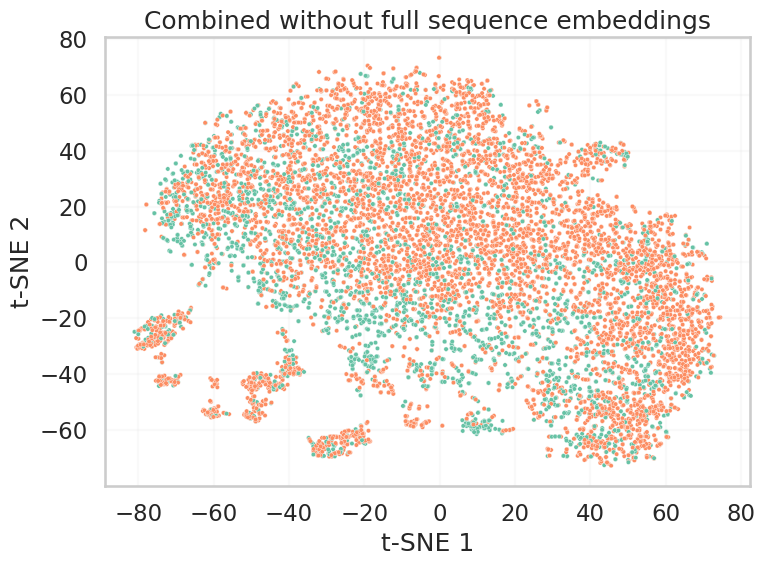

In [ ]:
# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=comb_embedding_tsne[:, 0], y=comb_embedding_tsne[:, 1],
                hue=df['y'],
                palette='Set2',
                alpha=1,
                s=10, legend = False)  # <-- point size control
plt.title('Combined without full sequence embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(alpha=0.1)
plt.tight_layout()
plt.savefig("comb_tsne.svg", format="svg", bbox_inches='tight')
plt.show()

Density overlap between classes: 0.7119


<ipython-input-86-1aa61302f273>:37: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
<ipython-input-86-1aa61302f273>:38: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')


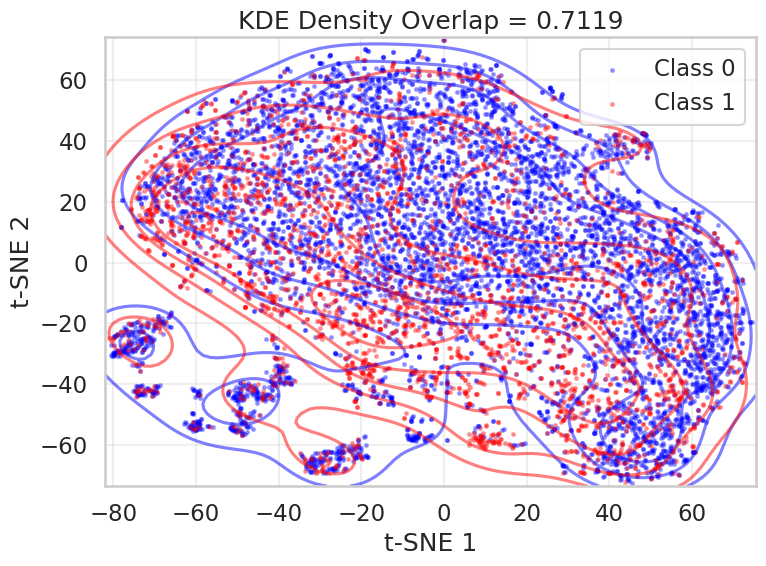

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Prepare data
X = comb_embedding_tsne
y = df['y'].values

# Split classes
class_0 = X[y == "negative"]
class_1 = X[y == "positive"]

# Create a grid over the data
xmin, ymin = X.min(axis=0) - 1
xmax, ymax = X.max(axis=0) + 1
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Estimate density for each class
kde_class_0 = gaussian_kde(class_0.T)
kde_class_1 = gaussian_kde(class_1.T)

density_0 = kde_class_0(positions)
density_1 = kde_class_1(positions)

# Normalize densities
density_0 /= density_0.sum()
density_1 /= density_1.sum()

# Overlap = sum of the minimum of densities at each point
overlap = np.sum(np.minimum(density_0, density_1))

print(f"Density overlap between classes: {overlap:.4f}")

# Visualize
plt.figure(figsize=(8, 6))
plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', s=5, alpha=0.3, label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', s=5, alpha=0.3, label='Class 1')
plt.title(f'KDE Density Overlap = {overlap:.4f}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Prepare data
X_tsne = comb_embedding_tsne
labels = df['y'].values  # assuming this is your label column

# Compute silhouette score
score = silhouette_score(X_tsne, labels)

print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0150


In [ ]:
# Combined t-SNE with Full
from sklearn.manifold import TSNE

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate='auto', init='random')
comb_embedding_tsne_w_full = tsne.fit_transform(combined_embeds_w_full)

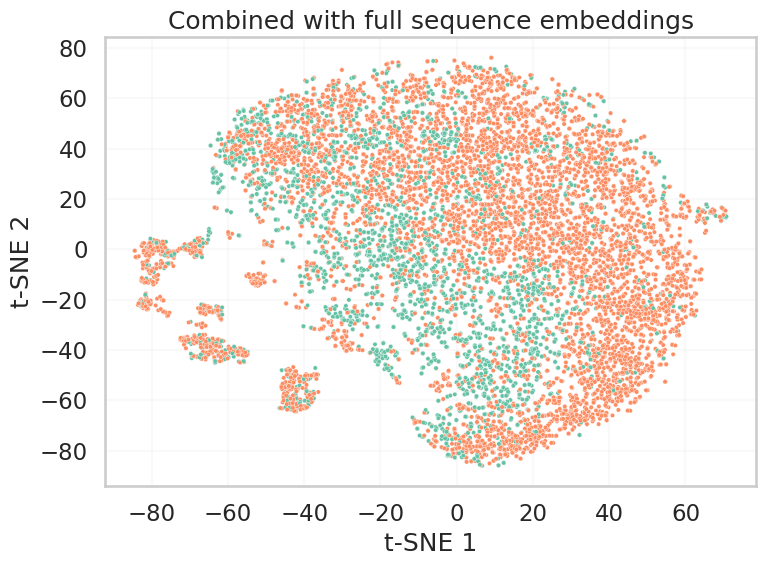

In [ ]:
# Plot t-SNE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=comb_embedding_tsne_w_full[:, 0], y=comb_embedding_tsne_w_full[:, 1],
                hue=df['y'],
                palette='Set2',
                alpha=1,
                s=10, legend = False)  # <-- point size control
plt.title('Combined with full sequence embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.grid(alpha=0.1)
plt.tight_layout()
plt.savefig("comb_w_full.svg", format="svg", bbox_inches='tight')
plt.show()

Density overlap between classes: 0.6036


<ipython-input-87-8e6978d26d7a>:37: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
<ipython-input-87-8e6978d26d7a>:38: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')


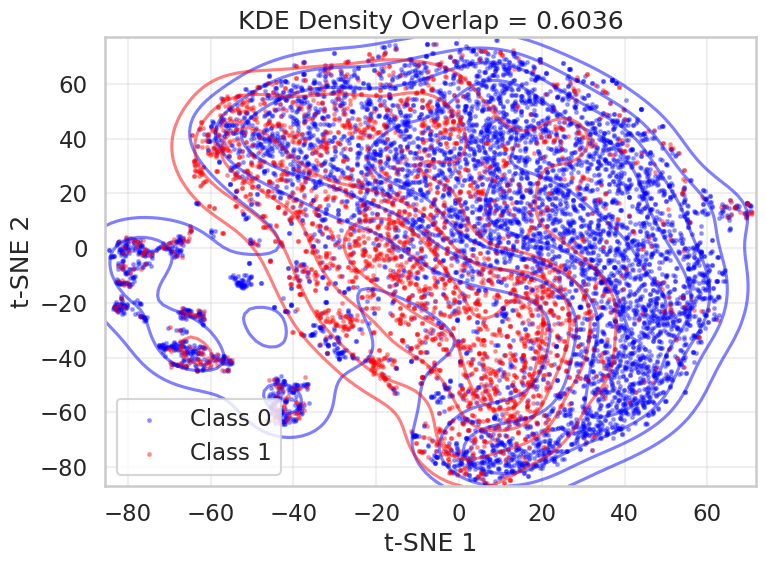

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Prepare data
X = comb_embedding_tsne_w_full
y = df['y'].values

# Split classes
class_0 = X[y == "negative"]
class_1 = X[y == "positive"]

# Create a grid over the data
xmin, ymin = X.min(axis=0) - 1
xmax, ymax = X.max(axis=0) + 1
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

# Estimate density for each class
kde_class_0 = gaussian_kde(class_0.T)
kde_class_1 = gaussian_kde(class_1.T)

density_0 = kde_class_0(positions)
density_1 = kde_class_1(positions)

# Normalize densities
density_0 /= density_0.sum()
density_1 /= density_1.sum()

# Overlap = sum of the minimum of densities at each point
overlap = np.sum(np.minimum(density_0, density_1))

print(f"Density overlap between classes: {overlap:.4f}")

# Visualize
plt.figure(figsize=(8, 6))
plt.contour(xx, yy, density_0.reshape(xx.shape), colors='blue', alpha=0.5, levels=5, label='Class 0 Density')
plt.contour(xx, yy, density_1.reshape(xx.shape), colors='red', alpha=0.5, levels=5, label='Class 1 Density')
plt.scatter(class_0[:, 0], class_0[:, 1], color='blue', s=5, alpha=0.3, label='Class 0')
plt.scatter(class_1[:, 0], class_1[:, 1], color='red', s=5, alpha=0.3, label='Class 1')
plt.title(f'KDE Density Overlap = {overlap:.4f}')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

# Prepare data
X_tsne = comb_embedding_tsne_w_full
labels = df['y'].values  # assuming this is your label column

# Compute silhouette score
score = silhouette_score(X_tsne, labels)

print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0181


# Training, validation, testing dataset split

In [127]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Read the DataFrame from the pickle file.
df = pd.read_pickle('/content/drive/MyDrive/evORFinder/datasets/datasubset_with_kmer_and_full_embeddings.pkl')

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

######################################
# 1. Load and Preprocess the Dataset #
######################################

# Map the target values: "positive" -> 1, "negative" -> 0
df = df[df['y'].isin(['positive', 'negative'])]
label_mapping = {'positive': 1, 'negative': 0}
df['label'] = df['y'].map(label_mapping)

######################################
# 2. Train/Validation/Test Split     #
######################################

# We perform an 80/10/10 split.
# Stratify on label to keep the class balance.
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Train samples: 8000
Validation samples: 1000
Test samples: 1000


# Sparse MoE on smorf_kmer, 20 epochs

In [128]:
######################################
# 3. Define a Custom Dataset         #
######################################

class kmerDataset(Dataset):
    def __init__(self, dataframe):
        self.embeddings = dataframe['kmer_smorf'].values
        self.labels = dataframe['label'].values

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        if not isinstance(emb, np.ndarray):
            emb = np.array(emb)
        emb_tensor = torch.tensor(emb, dtype=torch.float)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float)  # float for BCE loss
        return emb_tensor, label_tensor

# Create dataset objects and corresponding dataloaders
train_dataset = kmerDataset(train_df)
val_dataset = kmerDataset(val_df)
test_dataset = kmerDataset(test_df)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######################################
# 4. Define the Sparse MoE and Classifier Model #
######################################

# Define an Expert module (a simple 2-layer MLP).
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the Sparse MoE module.
class SparseMoE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        """
        Args:
            input_dim: Dimension of the input embedding.
            hidden_dim: Hidden layer size for each expert.
            num_experts: Total number of experts.
            k: Number of top experts to activate per sample.
        """
        super(SparseMoE, self).__init__()
        self.num_experts = num_experts
        self.k = k

        # Create a list of experts.
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim) for _ in range(num_experts)])
        # Gating network to score each expert.
        self.gate = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        batch_size = x.size(0)
        gate_scores = self.gate(x)  # shape: (batch_size, num_experts)
        # Select top-k experts per sample.
        topk_scores, topk_indices = gate_scores.topk(self.k, dim=1)

        # Compute output of each expert.
        expert_outputs = []
        for expert in self.experts:
            expert_outputs.append(expert(x))  # each: (batch_size, input_dim)
        expert_outputs = torch.stack(expert_outputs, dim=0)  # shape: (num_experts, batch_size, input_dim)

        # Combine outputs from the selected experts.
        output = torch.zeros(batch_size, x.size(1), device=x.device)
        for i in range(batch_size):
            for j in range(self.k):
                expert_idx = topk_indices[i, j]
                weight = topk_scores[i, j]
                output[i] += weight * expert_outputs[expert_idx, i]
        return output

# Define the overall classifier that uses the MoE module followed by a classification head.
class MoEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        super(MoEClassifier, self).__init__()
        self.moe = SparseMoE(input_dim, hidden_dim, num_experts, k)
        self.classifier = nn.Linear(input_dim, 1)  # Binary classification head.

    def forward(self, x):
        features = self.moe(x)
        logits = self.classifier(features)
        return logits

# Determine input dimension from one example embedding.
example_embedding = train_dataset[0][0]
input_dim = example_embedding.shape[0]
hidden_dim = 256    # Can be tuned.
num_experts = 8     # Adjust number of experts as desired.
k = 1               # Activate top-1 expert per sample.

model = MoEClassifier(input_dim, hidden_dim, num_experts, k).to(device)

######################################
# 5. Training Setup and Loop         #
######################################

criterion = nn.BCEWithLogitsLoss()  # Combines a sigmoid layer with the binary cross entropy loss.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20  # Adjust epochs as needed.

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        # Reshape labels to match logits shape: (batch_size, 1)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        logits = model(inputs)  # Output shape: (batch_size, 1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_dataset)

    # Evaluate on the validation set.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model(inputs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy.
            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_dataset)
    accuracy = correct / total * 100.0
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")

######################################
# 6. Evaluate on the Test Set        #
######################################

model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        logits = model(inputs)
        loss = criterion(logits, labels)
        test_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(logits) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_dataset)
accuracy = correct / total * 100.0
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Optionally, save the trained model.
torch.save(model.state_dict(), "kmer_moe_classifier.pth")
print("Model saved as 'kmer_moe_classifier.pth'.")

Epoch [1/20] - Train Loss: 0.6304 | Val Loss: 0.6044 | Val Acc: 70.70%
Epoch [2/20] - Train Loss: 0.5948 | Val Loss: 0.6062 | Val Acc: 70.50%
Epoch [3/20] - Train Loss: 0.5765 | Val Loss: 0.6020 | Val Acc: 70.60%
Epoch [4/20] - Train Loss: 0.5673 | Val Loss: 0.5979 | Val Acc: 70.10%
Epoch [5/20] - Train Loss: 0.5594 | Val Loss: 0.6192 | Val Acc: 69.10%
Epoch [6/20] - Train Loss: 0.5488 | Val Loss: 0.6147 | Val Acc: 69.20%
Epoch [7/20] - Train Loss: 0.5392 | Val Loss: 0.6422 | Val Acc: 67.60%
Epoch [8/20] - Train Loss: 0.5280 | Val Loss: 0.6103 | Val Acc: 70.10%
Epoch [9/20] - Train Loss: 0.5179 | Val Loss: 0.6267 | Val Acc: 70.30%
Epoch [10/20] - Train Loss: 0.5086 | Val Loss: 0.6474 | Val Acc: 69.80%
Epoch [11/20] - Train Loss: 0.4913 | Val Loss: 0.7173 | Val Acc: 66.00%
Epoch [12/20] - Train Loss: 0.4830 | Val Loss: 0.6877 | Val Acc: 66.90%
Epoch [13/20] - Train Loss: 0.4775 | Val Loss: 0.7302 | Val Acc: 66.60%
Epoch [14/20] - Train Loss: 0.4653 | Val Loss: 0.7383 | Val Acc: 68.30%
E

In [129]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Prepare full dataset
full_df = pd.concat([train_df, val_df]).reset_index(drop=True)
full_dataset = kmerDataset(full_df)

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# To store metrics
fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

batch_size = 32
num_epochs = 20
hidden_dim = 256
num_experts = 8
k = 1

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"\n--- Fold {fold + 1} ---")

    # Subsets for this fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Model instantiation
    example_embedding = full_dataset[0][0]
    input_dim = example_embedding.shape[0]
    model = MoEClassifier(input_dim, hidden_dim, num_experts, k).to(device)

    # Optimizer and loss
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            logits = model(inputs)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    # Store metrics
    fold_metrics['accuracy'].append(accuracy)
    fold_metrics['precision'].append(precision)
    fold_metrics['recall'].append(recall)
    fold_metrics['f1'].append(f1)
    fold_metrics['auc'].append(auc)

# Summary
print("\n=== Cross-Validation Results ===")
for metric, values in fold_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f} (folds: {values})")


--- Fold 1 ---
Fold 1 - Accuracy: 0.6678 | Precision: 0.4050 | Recall: 0.2779 | F1: 0.3296 | AUC: 0.6352

--- Fold 2 ---
Fold 2 - Accuracy: 0.6883 | Precision: 0.4026 | Recall: 0.2430 | F1: 0.3031 | AUC: 0.6153

--- Fold 3 ---
Fold 3 - Accuracy: 0.6772 | Precision: 0.4274 | Recall: 0.2955 | F1: 0.3494 | AUC: 0.6606

--- Fold 4 ---
Fold 4 - Accuracy: 0.6561 | Precision: 0.4222 | Recall: 0.3076 | F1: 0.3559 | AUC: 0.6425

--- Fold 5 ---
Fold 5 - Accuracy: 0.6683 | Precision: 0.4282 | Recall: 0.3271 | F1: 0.3709 | AUC: 0.6389

=== Cross-Validation Results ===
Accuracy: 0.6716 ± 0.0107 (folds: [0.6677777777777778, 0.6883333333333334, 0.6772222222222222, 0.6561111111111111, 0.6683333333333333])
Precision: 0.4171 ± 0.0111 (folds: [0.4049586776859504, 0.40264026402640263, 0.4273972602739726, 0.4222222222222222, 0.4282238442822384])
Recall: 0.2902 ± 0.0285 (folds: [0.277882797731569, 0.24302788844621515, 0.29545454545454547, 0.30755395683453235, 0.3271375464684015])
F1: 0.3418 ± 0.0235 (folds

# Sparse MoE on embedding_smorf, 20 epochs

In [130]:
######################################
# 3. Define a Custom Dataset         #
######################################

class EmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.embeddings = dataframe['embedding_smorf'].values
        self.labels = dataframe['label'].values

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        if not isinstance(emb, np.ndarray):
            emb = np.array(emb)
        emb_tensor = torch.tensor(emb, dtype=torch.float)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float)  # float for BCE loss
        return emb_tensor, label_tensor

# Create dataset objects and corresponding dataloaders
train_dataset = EmbeddingDataset(train_df)
val_dataset = EmbeddingDataset(val_df)
test_dataset = EmbeddingDataset(test_df)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######################################
# 4. Define the Sparse MoE and Classifier Model #
######################################

# Define an Expert module (a simple 2-layer MLP).
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the Sparse MoE module.
class SparseMoE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        """
        Args:
            input_dim: Dimension of the input embedding.
            hidden_dim: Hidden layer size for each expert.
            num_experts: Total number of experts.
            k: Number of top experts to activate per sample.
        """
        super(SparseMoE, self).__init__()
        self.num_experts = num_experts
        self.k = k

        # Create a list of experts.
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim) for _ in range(num_experts)])
        # Gating network to score each expert.
        self.gate = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        batch_size = x.size(0)
        gate_scores = self.gate(x)  # shape: (batch_size, num_experts)
        # Select top-k experts per sample.
        topk_scores, topk_indices = gate_scores.topk(self.k, dim=1)

        # Compute output of each expert.
        expert_outputs = []
        for expert in self.experts:
            expert_outputs.append(expert(x))  # each: (batch_size, input_dim)
        expert_outputs = torch.stack(expert_outputs, dim=0)  # shape: (num_experts, batch_size, input_dim)

        # Combine outputs from the selected experts.
        output = torch.zeros(batch_size, x.size(1), device=x.device)
        for i in range(batch_size):
            for j in range(self.k):
                expert_idx = topk_indices[i, j]
                weight = topk_scores[i, j]
                output[i] += weight * expert_outputs[expert_idx, i]
        return output

# Define the overall classifier that uses the MoE module followed by a classification head.
class MoEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        super(MoEClassifier, self).__init__()
        self.moe = SparseMoE(input_dim, hidden_dim, num_experts, k)
        self.classifier = nn.Linear(input_dim, 1)  # Binary classification head.

    def forward(self, x):
        features = self.moe(x)
        logits = self.classifier(features)
        return logits

# Determine input dimension from one example embedding.
example_embedding = train_dataset[0][0]
input_dim = example_embedding.shape[0]
hidden_dim = 256    # Can be tuned.
num_experts = 8     # Adjust number of experts as desired.
k = 1               # Activate top-1 expert per sample.

model = MoEClassifier(input_dim, hidden_dim, num_experts, k).to(device)

######################################
# 5. Training Setup and Loop         #
######################################

criterion = nn.BCEWithLogitsLoss()  # Combines a sigmoid layer with the binary cross entropy loss.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20  # Adjust epochs as needed.

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        # Reshape labels to match logits shape: (batch_size, 1)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        logits = model(inputs)  # Output shape: (batch_size, 1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_dataset)

    # Evaluate on the validation set.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model(inputs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy.
            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_dataset)
    accuracy = correct / total * 100.0
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")

######################################
# 6. Evaluate on the Test Set        #
######################################

model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        logits = model(inputs)
        loss = criterion(logits, labels)
        test_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(logits) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_dataset)
accuracy = correct / total * 100.0
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Optionally, save the trained model.
torch.save(model.state_dict(), "moe_classifier.pth")
print("Model saved as 'moe_classifier.pth'.")

Epoch [1/20] - Train Loss: 0.6342 | Val Loss: 0.5731 | Val Acc: 71.50%
Epoch [2/20] - Train Loss: 0.5556 | Val Loss: 0.5124 | Val Acc: 73.60%
Epoch [3/20] - Train Loss: 0.5504 | Val Loss: 0.5576 | Val Acc: 72.10%
Epoch [4/20] - Train Loss: 0.5368 | Val Loss: 0.5430 | Val Acc: 72.40%
Epoch [5/20] - Train Loss: 0.5450 | Val Loss: 0.5090 | Val Acc: 73.50%
Epoch [6/20] - Train Loss: 0.5290 | Val Loss: 0.5407 | Val Acc: 76.50%
Epoch [7/20] - Train Loss: 0.5247 | Val Loss: 0.5134 | Val Acc: 75.90%
Epoch [8/20] - Train Loss: 0.5272 | Val Loss: 0.4909 | Val Acc: 75.30%
Epoch [9/20] - Train Loss: 0.5232 | Val Loss: 0.5008 | Val Acc: 76.10%
Epoch [10/20] - Train Loss: 0.5253 | Val Loss: 0.4995 | Val Acc: 74.30%
Epoch [11/20] - Train Loss: 0.5209 | Val Loss: 0.5055 | Val Acc: 73.50%
Epoch [12/20] - Train Loss: 0.5261 | Val Loss: 0.5037 | Val Acc: 73.70%
Epoch [13/20] - Train Loss: 0.5170 | Val Loss: 0.5024 | Val Acc: 74.30%
Epoch [14/20] - Train Loss: 0.5183 | Val Loss: 0.5001 | Val Acc: 76.90%
E

In [131]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Prepare full dataset
full_df = pd.concat([train_df, val_df]).reset_index(drop=True)
full_dataset = EmbeddingDataset(full_df)

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# To store metrics
fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

batch_size = 32
num_epochs = 20
hidden_dim = 256
num_experts = 8
k = 1

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare data subsets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Determine input dimension dynamically
    example_embedding = full_dataset[0][0]
    input_dim = example_embedding.shape[0]

    # Instantiate model
    model = MoEClassifier(input_dim, hidden_dim, num_experts, k).to(device)

    # Define optimizer and loss
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_subset)

        # (Optional) Print train loss each epoch
        # print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}")

    # Evaluation
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            logits = model(inputs)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    # Store metrics
    fold_metrics['accuracy'].append(accuracy)
    fold_metrics['precision'].append(precision)
    fold_metrics['recall'].append(recall)
    fold_metrics['f1'].append(f1)
    fold_metrics['auc'].append(auc)

# Summary
print("\n=== Cross-Validation Results ===")
for metric, values in fold_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f} (folds: {values})")



--- Fold 1 ---
Fold 1 - Accuracy: 0.7683 | Precision: 0.6522 | Recall: 0.4537 | F1: 0.5351 | AUC: 0.8176

--- Fold 2 ---
Fold 2 - Accuracy: 0.7694 | Precision: 0.7377 | Recall: 0.2689 | F1: 0.3942 | AUC: 0.8105

--- Fold 3 ---
Fold 3 - Accuracy: 0.7717 | Precision: 0.6327 | Recall: 0.5284 | F1: 0.5759 | AUC: 0.8016

--- Fold 4 ---
Fold 4 - Accuracy: 0.7250 | Precision: 0.5670 | Recall: 0.4640 | F1: 0.5104 | AUC: 0.7796

--- Fold 5 ---
Fold 5 - Accuracy: 0.7600 | Precision: 0.6280 | Recall: 0.4833 | F1: 0.5462 | AUC: 0.8097

=== Cross-Validation Results ===
Accuracy: 0.7589 ± 0.0174 (folds: [0.7683333333333333, 0.7694444444444445, 0.7716666666666666, 0.725, 0.76])
Precision: 0.6435 ± 0.0551 (folds: [0.6521739130434783, 0.7377049180327869, 0.6326530612244898, 0.567032967032967, 0.6280193236714976])
Recall: 0.4397 ± 0.0891 (folds: [0.45368620037807184, 0.2689243027888446, 0.5284090909090909, 0.46402877697841727, 0.483271375464684])
F1: 0.5123 ± 0.0627 (folds: [0.5351170568561873, 0.39416

# Sparse MoE Hyperparameter Tuning

In [ ]:
import itertools
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Assume train_dataset and val_dataset are already created.
# Also assume device is set as:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

######################################
# Define a Custom Dataset         #
######################################

class EmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.embeddings = dataframe['embedding_smorf'].values
        self.labels = dataframe['label'].values

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        if not isinstance(emb, np.ndarray):
            emb = np.array(emb)
        emb_tensor = torch.tensor(emb, dtype=torch.float)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float)  # float for BCE loss
        return emb_tensor, label_tensor

# Create dataset objects and corresponding dataloaders
train_dataset = EmbeddingDataset(train_df)
val_dataset = EmbeddingDataset(val_df)

######################################
# Define the MoE Model Components    #
######################################

class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SparseMoE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        """
        Args:
            input_dim: Dimensionality of the input embedding.
            hidden_dim: Hidden layer size for each expert.
            num_experts: Total number of experts.
            k: Number of top experts to activate per sample.
        """
        super(SparseMoE, self).__init__()
        self.num_experts = num_experts
        self.k = k

        # Create experts.
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim) for _ in range(num_experts)])
        # Gating network to compute expert scores.
        self.gate = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        batch_size = x.size(0)
        gate_scores = self.gate(x)  # shape: (batch_size, num_experts)
        topk_scores, topk_indices = gate_scores.topk(self.k, dim=1)

        # Compute outputs from each expert.
        expert_outputs = [expert(x) for expert in self.experts]
        expert_outputs = torch.stack(expert_outputs, dim=0)  # shape: (num_experts, batch_size, input_dim)

        # Combine outputs from selected experts.
        output = torch.zeros(batch_size, x.size(1), device=x.device)
        for i in range(batch_size):
            for j in range(self.k):
                expert_idx = topk_indices[i, j]
                weight = topk_scores[i, j]
                output[i] += weight * expert_outputs[expert_idx, i]
        return output

class MoEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        super(MoEClassifier, self).__init__()
        self.moe = SparseMoE(input_dim, hidden_dim, num_experts, k)
        self.classifier = nn.Linear(input_dim, 1)  # Binary classification head.

    def forward(self, x):
        features = self.moe(x)
        logits = self.classifier(features)
        return logits

######################################
# Training Loop for Hyperparameter Tuning
######################################

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_acc = 0.0
    final_val_loss = None
    for epoch in range(num_epochs):
        # Training phase.
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)  # shape: (batch_size, 1)
            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase.
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1)
                logits = model(inputs)
                loss = criterion(logits, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.sigmoid(logits) >= 0.5
                correct += (preds.float() == labels).sum().item()
                total += labels.size(0)
        val_loss /= len(val_loader.dataset)
        val_acc = correct / total

        # Keep track of the best validation accuracy.
        best_val_acc = max(best_val_acc, val_acc)
        final_val_loss = val_loss

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.2f}%")
    return best_val_acc, final_val_loss

######################################
# Hyperparameter Grid Search         #
######################################

# Define DataLoaders for training and validation.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Determine input dimension from one example embedding.
input_dim = train_dataset[0][0].shape[0]

# Define hyperparameter ranges.
hidden_dims = [128, 256, 512]
num_experts_options = [2, 4, 8]
k_options = [1, 2]

results = []

for hidden_dim in hidden_dims:
    for num_experts in num_experts_options:
        for k in k_options:
            print(f"\nTraining with hidden_dim={hidden_dim}, num_experts={num_experts}, k={k}")
            # Initialize model for each combination.
            model = MoEClassifier(input_dim, hidden_dim, num_experts, k).to(device)
            optimizer = optim.Adam(model.parameters(), lr=1e-3)
            criterion = nn.BCEWithLogitsLoss()

            best_val_acc, final_val_loss = train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

            results.append({
                "hidden_dim": hidden_dim,
                "num_experts": num_experts,
                "k": k,
                "val_accuracy": best_val_acc,
                "val_loss": final_val_loss,
            })

# Convert the results to a DataFrame and display sorted by validation accuracy.
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("val_accuracy", ascending=False)
print("\nHyperparameter Tuning Results:")
print(results_df)


Training with hidden_dim=128, num_experts=2, k=1
Epoch [1/5] - Train Loss: 0.6261 | Val Loss: 0.5953 | Val Acc: 70.50%
Epoch [2/5] - Train Loss: 0.5863 | Val Loss: 0.5782 | Val Acc: 71.40%
Epoch [3/5] - Train Loss: 0.5693 | Val Loss: 0.5286 | Val Acc: 72.50%
Epoch [4/5] - Train Loss: 0.5402 | Val Loss: 0.5645 | Val Acc: 72.10%
Epoch [5/5] - Train Loss: 0.5354 | Val Loss: 0.4969 | Val Acc: 75.00%

Training with hidden_dim=128, num_experts=2, k=2
Epoch [1/5] - Train Loss: 0.6825 | Val Loss: 0.6212 | Val Acc: 72.70%
Epoch [2/5] - Train Loss: 0.5825 | Val Loss: 0.7058 | Val Acc: 71.50%
Epoch [3/5] - Train Loss: 0.5531 | Val Loss: 0.5284 | Val Acc: 74.60%
Epoch [4/5] - Train Loss: 0.5395 | Val Loss: 0.5174 | Val Acc: 75.60%
Epoch [5/5] - Train Loss: 0.5358 | Val Loss: 0.5812 | Val Acc: 74.80%

Training with hidden_dim=128, num_experts=4, k=1
Epoch [1/5] - Train Loss: 0.6085 | Val Loss: 0.5554 | Val Acc: 72.10%
Epoch [2/5] - Train Loss: 0.5735 | Val Loss: 0.5132 | Val Acc: 73.80%
Epoch [3/5

In [ ]:
import pandas as pd

# Define data
data = {
    "hidden_dim": [256, 256, 256, 128, 256, 128, 512, 256, 512, 128, 128, 512, 512, 128, 256, 128, 512, 512],
    "num_experts": [8, 8, 4, 8, 2, 2, 8, 4, 4, 8, 4, 8, 2, 2, 2, 4, 2, 4],
    "k": [1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2],
    "val_accuracy": [0.768, 0.765, 0.761, 0.757, 0.754, 0.752, 0.752, 0.751, 0.750, 0.750, 0.748, 0.748, 0.747, 0.746, 0.744, 0.736, 0.730, 0.727],
    "val_loss": [0.506545, 0.512832, 0.528869, 0.521786, 0.523880, 0.514080, 0.507726, 0.509734, 0.520249, 0.509855, 0.513070, 0.508335, 0.518998, 0.535090, 0.527919, 0.531148, 0.519302, 0.532023]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display DataFrame
print(df)


    hidden_dim  num_experts  k  val_accuracy  val_loss
0          256            8  1         0.768  0.506545
1          256            8  2         0.765  0.512832
2          256            4  2         0.761  0.528869
3          128            8  2         0.757  0.521786
4          256            2  1         0.754  0.523880
5          128            2  2         0.752  0.514080
6          512            8  2         0.752  0.507726
7          256            4  1         0.751  0.509734
8          512            4  1         0.750  0.520249
9          128            8  1         0.750  0.509855
10         128            4  1         0.748  0.513070
11         512            8  1         0.748  0.508335
12         512            2  1         0.747  0.518998
13         128            2  1         0.746  0.535090
14         256            2  2         0.744  0.527919
15         128            4  2         0.736  0.531148
16         512            2  2         0.730  0.519302
17        

<ipython-input-16-ddf0b607d3e3>:72: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


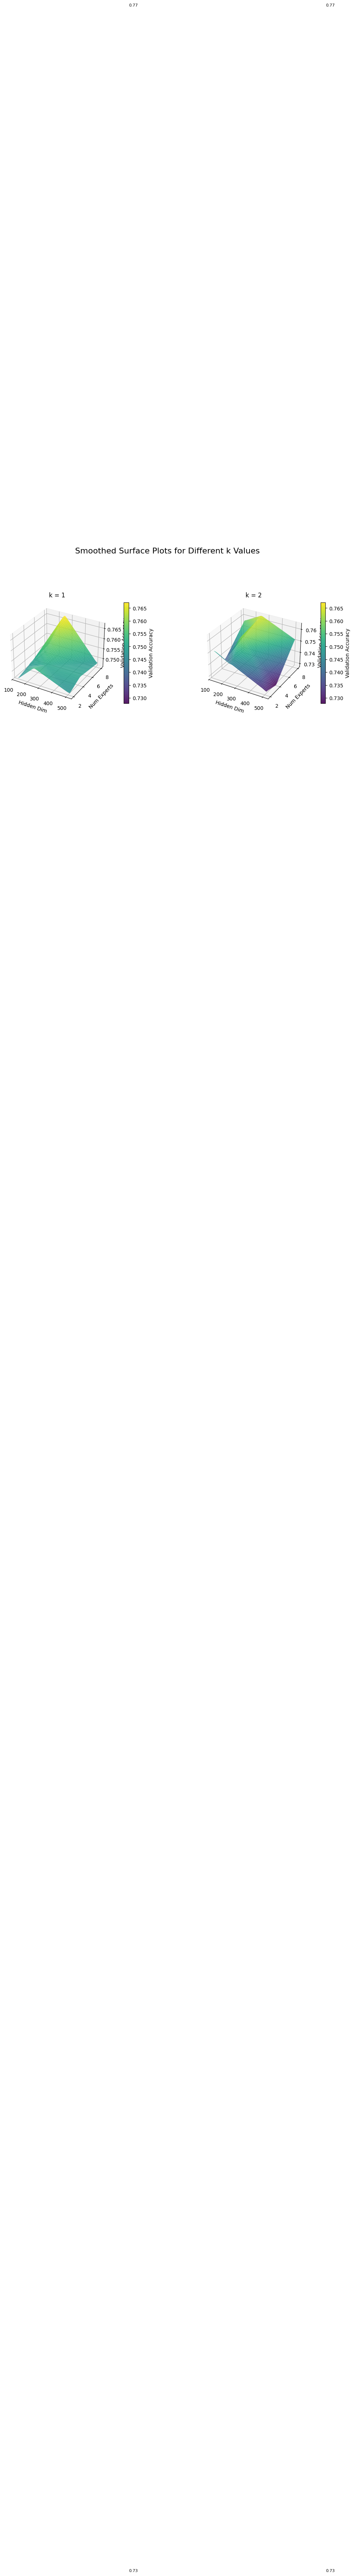

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from mpl_toolkits.mplot3d import Axes3D

# Prepare data points
x = df['hidden_dim']
y = df['num_experts']
z = df['k']
val = df['val_accuracy']

# Create grid for interpolation
grid_x, grid_y, grid_z = np.mgrid[
    x.min():x.max():100j,
    y.min():y.max():100j,
    z.min():z.max():100j
]

# Interpolate with linear interpolation (works in 3D)
grid_val = griddata(
    points=(x, y, z),
    values=val,
    xi=(grid_x, grid_y, grid_z),
    method='linear'
)

# Apply Gaussian smoothing
smoothed_grid_val = gaussian_filter(grid_val, sigma=2)

# Plot for unique values of k
unique_k_values = sorted(df['k'].unique())
num_plots = len(unique_k_values)

fig = plt.figure(figsize=(6 * num_plots, 6))

# Calculate global min and max for consistent color scale
vmin = np.nanmin(smoothed_grid_val)
vmax = np.nanmax(smoothed_grid_val)

for idx, k_value in enumerate(unique_k_values):
    ax = fig.add_subplot(1, num_plots, idx + 1, projection='3d')

    # Find the closest index in the grid to the desired k value
    k_idx = np.abs(grid_z[0, 0, :] - k_value).argmin()

    # Plot surface
    surf = ax.plot_surface(
        grid_x[:, :, k_idx],
        grid_y[:, :, k_idx],
        smoothed_grid_val[:, :, k_idx],
        cmap='viridis',
        edgecolor='none',
        alpha=0.9,
        vmin=vmin,
        vmax=vmax
    )

    ax.set_title(f'k = {k_value}', fontsize=12)
    ax.set_xlabel('Hidden Dim', fontsize=10)
    ax.set_ylabel('Num Experts', fontsize=10)
    ax.set_zlabel('Validation Accuracy', fontsize=10)

    # Colorbar with min/max values
    cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20, pad=0.1)
    cbar.set_label('Validation Accuracy', fontsize=10)
    cbar.ax.text(1.05, 0, f'{vmin:.2f}', va='center', ha='left', fontsize=8)
    cbar.ax.text(1.05, 1, f'{vmax:.2f}', va='center', ha='left', fontsize=8)

plt.suptitle('Smoothed Surface Plots for Different k Values', fontsize=16)
plt.subplots_adjust(wspace=0.4)  # spacing between plots
plt.tight_layout()

# Save as SVG
plt.savefig("smoothed_surface_plots.svg", format="svg")

plt.show()

# Sparse MoE on embedding_smorf, 100 epochs

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

######################################
# 3. Define a Custom Dataset         #
######################################

class EmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.embeddings = dataframe['embedding_smorf'].values
        self.labels = dataframe['label'].values

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        if not isinstance(emb, np.ndarray):
            emb = np.array(emb)
        emb_tensor = torch.tensor(emb, dtype=torch.float)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float)  # float for BCE loss
        return emb_tensor, label_tensor

# Create dataset objects and corresponding dataloaders
train_dataset = EmbeddingDataset(train_df)
val_dataset = EmbeddingDataset(val_df)
test_dataset = EmbeddingDataset(test_df)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######################################
# 4. Define the Sparse MoE and Classifier Model #
######################################

# Define an Expert module (a simple 2-layer MLP).
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the Sparse MoE module.
class SparseMoE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        """
        Args:
            input_dim: Dimension of the input embedding.
            hidden_dim: Hidden layer size for each expert.
            num_experts: Total number of experts.
            k: Number of top experts to activate per sample.
        """
        super(SparseMoE, self).__init__()
        self.num_experts = num_experts
        self.k = k

        # Create a list of experts.
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim) for _ in range(num_experts)])
        # Gating network to score each expert.
        self.gate = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        batch_size = x.size(0)
        gate_scores = self.gate(x)  # shape: (batch_size, num_experts)
        # Select top-k experts per sample.
        topk_scores, topk_indices = gate_scores.topk(self.k, dim=1)

        # Compute output of each expert.
        expert_outputs = []
        for expert in self.experts:
            expert_outputs.append(expert(x))  # each: (batch_size, input_dim)
        expert_outputs = torch.stack(expert_outputs, dim=0)  # shape: (num_experts, batch_size, input_dim)

        # Combine outputs from the selected experts.
        output = torch.zeros(batch_size, x.size(1), device=x.device)
        for i in range(batch_size):
            for j in range(self.k):
                expert_idx = topk_indices[i, j]
                weight = topk_scores[i, j]
                output[i] += weight * expert_outputs[expert_idx, i]
        return output

# Define the overall classifier that uses the MoE module followed by a classification head.
class MoEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        super(MoEClassifier, self).__init__()
        self.moe = SparseMoE(input_dim, hidden_dim, num_experts, k)
        self.classifier = nn.Linear(input_dim, 1)  # Binary classification head.

    def forward(self, x):
        features = self.moe(x)
        logits = self.classifier(features)
        return logits

# Determine input dimension from one example embedding.
example_embedding = train_dataset[0][0]
input_dim = example_embedding.shape[0]
hidden_dim = 256    # Can be tuned.
num_experts = 8     # Adjust number of experts as desired.
k = 1               # Activate top-1 expert per sample.

model = MoEClassifier(input_dim, hidden_dim, num_experts, k).to(device)

######################################
# 5. Training Setup and Loop         #
######################################

criterion = nn.BCEWithLogitsLoss()  # Combines a sigmoid layer with the binary cross entropy loss.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20  # Adjust epochs as needed.

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        # Reshape labels to match logits shape: (batch_size, 1)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        logits = model(inputs)  # Output shape: (batch_size, 1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_dataset)

    # Evaluate on the validation set.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model(inputs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy.
            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_dataset)
    accuracy = correct / total * 100.0
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")

######################################
# 6. Evaluate on the Test Set        #
######################################

model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        logits = model(inputs)
        loss = criterion(logits, labels)
        test_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(logits) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_dataset)
accuracy = correct / total * 100.0
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Optionally, save the trained model.
torch.save(model.state_dict(), "moe_classifier.pth")
print("Model saved as 'moe_classifier.pth'.")

Train samples: 8000
Validation samples: 1000
Test samples: 1000
Epoch [1/100] - Train Loss: 0.6141 | Val Loss: 0.6170 | Val Acc: 70.50%
Epoch [2/100] - Train Loss: 0.8364 | Val Loss: 0.6141 | Val Acc: 70.50%
Epoch [3/100] - Train Loss: 0.6146 | Val Loss: 0.6071 | Val Acc: 70.50%
Epoch [4/100] - Train Loss: 0.6097 | Val Loss: 0.6047 | Val Acc: 70.50%
Epoch [5/100] - Train Loss: 0.6072 | Val Loss: 0.6048 | Val Acc: 70.50%
Epoch [6/100] - Train Loss: 0.6072 | Val Loss: 0.6041 | Val Acc: 70.50%
Epoch [7/100] - Train Loss: 0.6028 | Val Loss: 0.5998 | Val Acc: 70.50%
Epoch [8/100] - Train Loss: 0.5989 | Val Loss: 0.5928 | Val Acc: 70.90%
Epoch [9/100] - Train Loss: 0.5846 | Val Loss: 0.5495 | Val Acc: 74.20%
Epoch [10/100] - Train Loss: 0.5447 | Val Loss: 0.5581 | Val Acc: 70.80%
Epoch [11/100] - Train Loss: 0.5410 | Val Loss: 0.5491 | Val Acc: 75.30%
Epoch [12/100] - Train Loss: 0.5289 | Val Loss: 0.5307 | Val Acc: 72.80%
Epoch [13/100] - Train Loss: 0.5296 | Val Loss: 0.5056 | Val Acc: 75.

# smORFinder architecture on kmer_smorf, kmer_upstream, kmer_downstream, 20 epochs

In [136]:
import os
import pandas as pd
import numpy as np
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

######################################
# 3. Create a Custom Dataset         #
######################################

class kmerMultiDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Convert embeddings to torch tensors (assume embeddings are list-like).
        upstream = torch.tensor(np.array(row['kmer_upstream']), dtype=torch.float)
        downstream = torch.tensor(np.array(row['kmer_downstream']), dtype=torch.float)
        smorf = torch.tensor(np.array(row['kmer_smorf']), dtype=torch.float)
        label = torch.tensor(row['label'], dtype=torch.float)  # for BCEWithLogitsLoss
        return upstream, downstream, smorf, label

# Create dataset objects.
train_dataset = kmerMultiDataset(train_df)
val_dataset = kmerMultiDataset(val_df)
test_dataset = kmerMultiDataset(test_df)

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######################################
# 4. Define the Multi-Embedding Model #
######################################

class MultiEmbeddingClassifier(nn.Module):
    def __init__(self, upstream_dim, downstream_dim, smorf_dim, hidden_dim, output_dim=1, dropout=0.5):
        """
        Args:
            upstream_dim: Dimension of the upstream embedding.
            downstream_dim: Dimension of the downstream embedding.
            smorf_dim: Dimension of the smorf embedding.
            hidden_dim: Hidden layer size for each branch.
            output_dim: Number of outputs (1 for binary classification).
            dropout: Dropout probability.
        """
        super(MultiEmbeddingClassifier, self).__init__()
        # Sub-network for upstream embeddings.
        self.upstream_net = nn.Sequential(
            nn.Linear(upstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Sub-network for downstream embeddings.
        self.downstream_net = nn.Sequential(
            nn.Linear(downstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Sub-network for smorf embeddings.
        self.smorf_net = nn.Sequential(
            nn.Linear(smorf_dim, hidden_dim),
            nn.ReLU()
        )
        # Classifier combining the three branches.
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, upstream, downstream, smorf):
        # Process each embedding through its corresponding network.
        upstream_feat = self.upstream_net(upstream)
        downstream_feat = self.downstream_net(downstream)
        smorf_feat = self.smorf_net(smorf)
        # Late fusion via concatenation.
        combined = torch.cat([upstream_feat, downstream_feat, smorf_feat], dim=1)
        logits = self.classifier(combined)
        return logits

# Determine embedding dimensions from one sample.
example_upstream, example_downstream, example_smorf, _ = train_dataset[0]
upstream_dim = example_upstream.shape[0]
downstream_dim = example_downstream.shape[0]
smorf_dim = example_smorf.shape[0]

hidden_dim = 256  # You can tune this hyperparameter.
model = MultiEmbeddingClassifier(upstream_dim, downstream_dim, smorf_dim, hidden_dim).to(device)

######################################
# 5. Training Setup and Loop         #
######################################

criterion = nn.BCEWithLogitsLoss()  # For binary classification.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

for epoch in range(num_epochs):
    # Training phase.
    model.train()
    train_loss = 0.0
    for upstream, downstream, smorf, labels in train_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        labels = labels.to(device).unsqueeze(1)  # shape: (batch_size, 1)

        optimizer.zero_grad()
        logits = model(upstream, downstream, smorf)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * upstream.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation phase.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for upstream, downstream, smorf, labels in val_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model(upstream, downstream, smorf)
            loss = criterion(logits, labels)
            val_loss += loss.item() * upstream.size(0)

            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader.dataset)
    val_acc = correct / total * 100.0
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

######################################
# 6. Testing the Model               #
######################################

model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for upstream, downstream, smorf, labels in test_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        labels = labels.to(device).unsqueeze(1)
        logits = model(upstream, downstream, smorf)
        loss = criterion(logits, labels)
        test_loss += loss.item() * upstream.size(0)

        preds = torch.sigmoid(logits) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)
test_loss /= len(test_loader.dataset)
test_acc = correct / total * 100.0
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# Optionally, save the trained model.
torch.save(model.state_dict(), "multi_kmer_classifier.pth")
print("Model saved as 'multi_kmer_classifier.pth'.")

Epoch [1/20] - Train Loss: 0.5990 | Val Loss: 0.5925 | Val Acc: 70.50%
Epoch [2/20] - Train Loss: 0.5736 | Val Loss: 0.5920 | Val Acc: 70.50%
Epoch [3/20] - Train Loss: 0.5575 | Val Loss: 0.6141 | Val Acc: 69.90%
Epoch [4/20] - Train Loss: 0.5438 | Val Loss: 0.6043 | Val Acc: 70.40%
Epoch [5/20] - Train Loss: 0.5258 | Val Loss: 0.6154 | Val Acc: 67.50%
Epoch [6/20] - Train Loss: 0.5086 | Val Loss: 0.6248 | Val Acc: 69.70%
Epoch [7/20] - Train Loss: 0.4837 | Val Loss: 0.6543 | Val Acc: 69.80%
Epoch [8/20] - Train Loss: 0.4542 | Val Loss: 0.6364 | Val Acc: 63.00%
Epoch [9/20] - Train Loss: 0.4250 | Val Loss: 0.6872 | Val Acc: 61.50%
Epoch [10/20] - Train Loss: 0.4044 | Val Loss: 0.6822 | Val Acc: 66.60%
Epoch [11/20] - Train Loss: 0.3639 | Val Loss: 0.8107 | Val Acc: 69.10%
Epoch [12/20] - Train Loss: 0.3340 | Val Loss: 0.8527 | Val Acc: 66.80%
Epoch [13/20] - Train Loss: 0.3043 | Val Loss: 0.8830 | Val Acc: 65.10%
Epoch [14/20] - Train Loss: 0.2808 | Val Loss: 0.9932 | Val Acc: 65.70%
E

In [137]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Prepare full dataset
full_df = pd.concat([train_df, val_df]).reset_index(drop=True)
full_dataset = kmerMultiDataset(full_df)

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# To store metrics
fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

batch_size = 32
num_epochs = 20
hidden_dim = 256

# Determine embedding dimensions from one sample
example_upstream, example_downstream, example_smorf, _ = full_dataset[0]
upstream_dim = example_upstream.shape[0]
downstream_dim = example_downstream.shape[0]
smorf_dim = example_smorf.shape[0]

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare data subsets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Instantiate model
    model = MultiEmbeddingClassifier(upstream_dim, downstream_dim, smorf_dim, hidden_dim).to(device)

    # Define optimizer and loss
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for upstream, downstream, smorf, labels in train_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            logits = model(upstream, downstream, smorf)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * upstream.size(0)

        train_loss = running_loss / len(train_subset)
        # Optional: print train loss
        # print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}")

    # Evaluation
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for upstream, downstream, smorf, labels in val_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            labels = labels.to(device).unsqueeze(1)

            logits = model(upstream, downstream, smorf)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    # Store metrics
    fold_metrics['accuracy'].append(accuracy)
    fold_metrics['precision'].append(precision)
    fold_metrics['recall'].append(recall)
    fold_metrics['f1'].append(f1)
    fold_metrics['auc'].append(auc)

# Summary
print("\n=== Cross-Validation Results ===")
for metric, values in fold_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f} (folds: {values})")



--- Fold 1 ---
Fold 1 - Accuracy: 0.6494 | Precision: 0.4059 | Recall: 0.4159 | F1: 0.4108 | AUC: 0.6420

--- Fold 2 ---
Fold 2 - Accuracy: 0.6833 | Precision: 0.4029 | Recall: 0.2809 | F1: 0.3310 | AUC: 0.6423

--- Fold 3 ---
Fold 3 - Accuracy: 0.6539 | Precision: 0.4052 | Recall: 0.3845 | F1: 0.3946 | AUC: 0.6462

--- Fold 4 ---
Fold 4 - Accuracy: 0.6478 | Precision: 0.4148 | Recall: 0.3417 | F1: 0.3748 | AUC: 0.6514

--- Fold 5 ---
Fold 5 - Accuracy: 0.6506 | Precision: 0.4066 | Recall: 0.3680 | F1: 0.3863 | AUC: 0.6406

=== Cross-Validation Results ===
Accuracy: 0.6570 ± 0.0133 (folds: [0.6494444444444445, 0.6833333333333333, 0.6538888888888889, 0.6477777777777778, 0.6505555555555556])
Precision: 0.4071 ± 0.0041 (folds: [0.4059040590405904, 0.40285714285714286, 0.405189620758483, 0.4148471615720524, 0.406570841889117])
Recall: 0.3582 ± 0.0455 (folds: [0.4158790170132325, 0.28087649402390436, 0.38446969696969696, 0.34172661870503596, 0.3680297397769517])
F1: 0.3795 ± 0.0269 (folds:

# smORFinder architecture on embedding_smorf, embedding_upstream, embedding_downstream, 20 epochs

In [133]:
import os
import pandas as pd
import numpy as np
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

######################################
# 3. Create a Custom Dataset         #
######################################

class MultiEmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Convert embeddings to torch tensors (assume embeddings are list-like).
        upstream = torch.tensor(np.array(row['embedding_upstream']), dtype=torch.float)
        downstream = torch.tensor(np.array(row['embedding_downstream']), dtype=torch.float)
        smorf = torch.tensor(np.array(row['embedding_smorf']), dtype=torch.float)
        label = torch.tensor(row['label'], dtype=torch.float)  # for BCEWithLogitsLoss
        return upstream, downstream, smorf, label

# Create dataset objects.
train_dataset = MultiEmbeddingDataset(train_df)
val_dataset = MultiEmbeddingDataset(val_df)
test_dataset = MultiEmbeddingDataset(test_df)

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######################################
# 4. Define the Multi-Embedding Model #
######################################

class MultiEmbeddingClassifier(nn.Module):
    def __init__(self, upstream_dim, downstream_dim, smorf_dim, hidden_dim, output_dim=1, dropout=0.5):
        """
        Args:
            upstream_dim: Dimension of the upstream embedding.
            downstream_dim: Dimension of the downstream embedding.
            smorf_dim: Dimension of the smorf embedding.
            hidden_dim: Hidden layer size for each branch.
            output_dim: Number of outputs (1 for binary classification).
            dropout: Dropout probability.
        """
        super(MultiEmbeddingClassifier, self).__init__()
        # Sub-network for upstream embeddings.
        self.upstream_net = nn.Sequential(
            nn.Linear(upstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Sub-network for downstream embeddings.
        self.downstream_net = nn.Sequential(
            nn.Linear(downstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Sub-network for smorf embeddings.
        self.smorf_net = nn.Sequential(
            nn.Linear(smorf_dim, hidden_dim),
            nn.ReLU()
        )
        # Classifier combining the three branches.
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, upstream, downstream, smorf):
        # Process each embedding through its corresponding network.
        upstream_feat = self.upstream_net(upstream)
        downstream_feat = self.downstream_net(downstream)
        smorf_feat = self.smorf_net(smorf)
        # Late fusion via concatenation.
        combined = torch.cat([upstream_feat, downstream_feat, smorf_feat], dim=1)
        logits = self.classifier(combined)
        return logits

# Determine embedding dimensions from one sample.
example_upstream, example_downstream, example_smorf, _ = train_dataset[0]
upstream_dim = example_upstream.shape[0]
downstream_dim = example_downstream.shape[0]
smorf_dim = example_smorf.shape[0]

hidden_dim = 256  # You can tune this hyperparameter.
model = MultiEmbeddingClassifier(upstream_dim, downstream_dim, smorf_dim, hidden_dim).to(device)

######################################
# 5. Training Setup and Loop         #
######################################

criterion = nn.BCEWithLogitsLoss()  # For binary classification.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

for epoch in range(num_epochs):
    # Training phase.
    model.train()
    train_loss = 0.0
    for upstream, downstream, smorf, labels in train_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        labels = labels.to(device).unsqueeze(1)  # shape: (batch_size, 1)

        optimizer.zero_grad()
        logits = model(upstream, downstream, smorf)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * upstream.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation phase.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for upstream, downstream, smorf, labels in val_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model(upstream, downstream, smorf)
            loss = criterion(logits, labels)
            val_loss += loss.item() * upstream.size(0)

            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader.dataset)
    val_acc = correct / total * 100.0
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

######################################
# 6. Testing the Model               #
######################################

model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for upstream, downstream, smorf, labels in test_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        labels = labels.to(device).unsqueeze(1)
        logits = model(upstream, downstream, smorf)
        loss = criterion(logits, labels)
        test_loss += loss.item() * upstream.size(0)

        preds = torch.sigmoid(logits) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)
test_loss /= len(test_loader.dataset)
test_acc = correct / total * 100.0
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# Optionally, save the trained model.
torch.save(model.state_dict(), "multi_embedding_classifier.pth")
print("Model saved as 'multi_embedding_classifier.pth'.")

Epoch [1/20] - Train Loss: 0.6210 | Val Loss: 0.5971 | Val Acc: 70.50%
Epoch [2/20] - Train Loss: 0.5768 | Val Loss: 0.5326 | Val Acc: 72.60%
Epoch [3/20] - Train Loss: 0.6204 | Val Loss: 0.6001 | Val Acc: 70.50%
Epoch [4/20] - Train Loss: 0.6022 | Val Loss: 0.5931 | Val Acc: 70.50%
Epoch [5/20] - Train Loss: 0.5968 | Val Loss: 0.5907 | Val Acc: 70.50%
Epoch [6/20] - Train Loss: 0.5893 | Val Loss: 0.5788 | Val Acc: 70.50%
Epoch [7/20] - Train Loss: 0.5849 | Val Loss: 0.5725 | Val Acc: 70.50%
Epoch [8/20] - Train Loss: 0.5855 | Val Loss: 0.5810 | Val Acc: 70.50%
Epoch [9/20] - Train Loss: 0.5835 | Val Loss: 0.5949 | Val Acc: 70.50%
Epoch [10/20] - Train Loss: 0.5785 | Val Loss: 0.5652 | Val Acc: 70.60%
Epoch [11/20] - Train Loss: 0.5793 | Val Loss: 0.5634 | Val Acc: 72.30%
Epoch [12/20] - Train Loss: 0.5741 | Val Loss: 0.5683 | Val Acc: 71.90%
Epoch [13/20] - Train Loss: 0.5815 | Val Loss: 0.5620 | Val Acc: 70.50%
Epoch [14/20] - Train Loss: 0.5767 | Val Loss: 0.5596 | Val Acc: 71.90%
E

In [138]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Prepare full dataset
full_df = pd.concat([train_df, val_df]).reset_index(drop=True)
full_dataset = MultiEmbeddingDataset(full_df)

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# To store metrics
fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

batch_size = 32
num_epochs = 20
hidden_dim = 256

# Determine embedding dimensions from one sample
example_upstream, example_downstream, example_smorf, _ = full_dataset[0]
upstream_dim = example_upstream.shape[0]
downstream_dim = example_downstream.shape[0]
smorf_dim = example_smorf.shape[0]

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare data subsets
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Instantiate model
    model = MultiEmbeddingClassifier(upstream_dim, downstream_dim, smorf_dim, hidden_dim).to(device)

    # Define optimizer and loss
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for upstream, downstream, smorf, labels in train_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            logits = model(upstream, downstream, smorf)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * upstream.size(0)

        train_loss = running_loss / len(train_subset)

        # Optional: print train loss
        # print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}")

    # Evaluation
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for upstream, downstream, smorf, labels in val_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            labels = labels.to(device).unsqueeze(1)

            logits = model(upstream, downstream, smorf)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    # Store metrics
    fold_metrics['accuracy'].append(accuracy)
    fold_metrics['precision'].append(precision)
    fold_metrics['recall'].append(recall)
    fold_metrics['f1'].append(f1)
    fold_metrics['auc'].append(auc)

# Summary
print("\n=== Cross-Validation Results ===")
for metric, values in fold_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f} (folds: {values})")



--- Fold 1 ---
Fold 1 - Accuracy: 0.7606 | Precision: 0.5984 | Recall: 0.5633 | F1: 0.5803 | AUC: 0.8158

--- Fold 2 ---
Fold 2 - Accuracy: 0.7861 | Precision: 0.6410 | Recall: 0.5299 | F1: 0.5802 | AUC: 0.8205

--- Fold 3 ---
Fold 3 - Accuracy: 0.7728 | Precision: 0.6133 | Recall: 0.6098 | F1: 0.6116 | AUC: 0.8161

--- Fold 4 ---
Fold 4 - Accuracy: 0.8128 | Precision: 0.7118 | Recall: 0.6619 | F1: 0.6859 | AUC: 0.8576

--- Fold 5 ---
Fold 5 - Accuracy: 0.7822 | Precision: 0.6197 | Recall: 0.7026 | F1: 0.6585 | AUC: 0.8418

=== Cross-Validation Results ===
Accuracy: 0.7829 ± 0.0174 (folds: [0.7605555555555555, 0.7861111111111111, 0.7727777777777778, 0.8127777777777778, 0.7822222222222223])
Precision: 0.6368 ± 0.0399 (folds: [0.5983935742971888, 0.6409638554216868, 0.6133333333333333, 0.7117988394584139, 0.6196721311475409])
Recall: 0.6135 ± 0.0629 (folds: [0.5633270321361059, 0.5298804780876494, 0.6098484848484849, 0.6618705035971223, 0.7026022304832714])
F1: 0.6233 ± 0.0424 (folds: [

# Sparse MoE trained on kmer_full, 20 epoch

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

######################################
# 3. Define a Custom Dataset         #
######################################

class kmerDataset(Dataset):
    def __init__(self, dataframe):
        self.embeddings = dataframe['kmer_full'].values
        self.labels = dataframe['label'].values

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        if not isinstance(emb, np.ndarray):
            emb = np.array(emb)
        emb_tensor = torch.tensor(emb, dtype=torch.float)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float)  # float for BCE loss
        return emb_tensor, label_tensor

# Create dataset objects and corresponding dataloaders
train_dataset = kmerDataset(train_df)
val_dataset = kmerDataset(val_df)
test_dataset = kmerDataset(test_df)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######################################
# 4. Define the Sparse MoE and Classifier Model #
######################################

# Define an Expert module (a simple 2-layer MLP).
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the Sparse MoE module.
class SparseMoE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        """
        Args:
            input_dim: Dimension of the input embedding.
            hidden_dim: Hidden layer size for each expert.
            num_experts: Total number of experts.
            k: Number of top experts to activate per sample.
        """
        super(SparseMoE, self).__init__()
        self.num_experts = num_experts
        self.k = k

        # Create a list of experts.
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim) for _ in range(num_experts)])
        # Gating network to score each expert.
        self.gate = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        batch_size = x.size(0)
        gate_scores = self.gate(x)  # shape: (batch_size, num_experts)
        # Select top-k experts per sample.
        topk_scores, topk_indices = gate_scores.topk(self.k, dim=1)

        # Compute output of each expert.
        expert_outputs = []
        for expert in self.experts:
            expert_outputs.append(expert(x))  # each: (batch_size, input_dim)
        expert_outputs = torch.stack(expert_outputs, dim=0)  # shape: (num_experts, batch_size, input_dim)

        # Combine outputs from the selected experts.
        output = torch.zeros(batch_size, x.size(1), device=x.device)
        for i in range(batch_size):
            for j in range(self.k):
                expert_idx = topk_indices[i, j]
                weight = topk_scores[i, j]
                output[i] += weight * expert_outputs[expert_idx, i]
        return output

# Define the overall classifier that uses the MoE module followed by a classification head.
class MoEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        super(MoEClassifier, self).__init__()
        self.moe = SparseMoE(input_dim, hidden_dim, num_experts, k)
        self.classifier = nn.Linear(input_dim, 1)  # Binary classification head.

    def forward(self, x):
        features = self.moe(x)
        logits = self.classifier(features)
        return logits

# Determine input dimension from one example embedding.
example_embedding = train_dataset[0][0]
input_dim = example_embedding.shape[0]
hidden_dim = 256    # Can be tuned.
num_experts = 8     # Adjust number of experts as desired.
k = 1               # Activate top-1 expert per sample.

model = MoEClassifier(input_dim, hidden_dim, num_experts, k).to(device)

######################################
# 5. Training Setup and Loop         #
######################################

criterion = nn.BCEWithLogitsLoss()  # Combines a sigmoid layer with the binary cross entropy loss.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20  # Adjust epochs as needed.

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        # Reshape labels to match logits shape: (batch_size, 1)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        logits = model(inputs)  # Output shape: (batch_size, 1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_dataset)

    # Evaluate on the validation set.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model(inputs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy.
            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_dataset)
    accuracy = correct / total * 100.0
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")

######################################
# 6. Evaluate on the Test Set        #
######################################

model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        logits = model(inputs)
        loss = criterion(logits, labels)
        test_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(logits) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_dataset)
accuracy = correct / total * 100.0
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Optionally, save the trained model.
torch.save(model.state_dict(), "kmer_full_moe_classifier.pth")
print("Model saved as 'kmer_full_moe_classifier.pth'.")

Epoch [1/20] - Train Loss: 0.7142 | Val Loss: 0.6049 | Val Acc: 70.50%
Epoch [2/20] - Train Loss: 0.6023 | Val Loss: 0.6054 | Val Acc: 70.40%
Epoch [3/20] - Train Loss: 0.5931 | Val Loss: 0.5970 | Val Acc: 70.40%
Epoch [4/20] - Train Loss: 0.5836 | Val Loss: 0.6051 | Val Acc: 70.40%
Epoch [5/20] - Train Loss: 0.5807 | Val Loss: 0.6021 | Val Acc: 70.20%
Epoch [6/20] - Train Loss: 0.5816 | Val Loss: 0.5960 | Val Acc: 70.40%
Epoch [7/20] - Train Loss: 0.5783 | Val Loss: 0.5981 | Val Acc: 70.40%
Epoch [8/20] - Train Loss: 0.5732 | Val Loss: 0.5953 | Val Acc: 70.50%
Epoch [9/20] - Train Loss: 0.5725 | Val Loss: 0.6123 | Val Acc: 70.10%
Epoch [10/20] - Train Loss: 0.5667 | Val Loss: 0.6094 | Val Acc: 69.40%
Epoch [11/20] - Train Loss: 0.5657 | Val Loss: 0.6182 | Val Acc: 69.70%
Epoch [12/20] - Train Loss: 0.5611 | Val Loss: 0.5993 | Val Acc: 70.00%
Epoch [13/20] - Train Loss: 0.5568 | Val Loss: 0.6418 | Val Acc: 67.20%
Epoch [14/20] - Train Loss: 0.5520 | Val Loss: 0.6103 | Val Acc: 69.70%
E

# Sparse MoE on full_smorf, 20 epochs

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

######################################
# 3. Define a Custom Dataset         #
######################################

class EmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.embeddings = dataframe['embedding_full'].values
        self.labels = dataframe['label'].values

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        emb = self.embeddings[idx]
        if not isinstance(emb, np.ndarray):
            emb = np.array(emb)
        emb_tensor = torch.tensor(emb, dtype=torch.float)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.float)  # float for BCE loss
        return emb_tensor, label_tensor

# Create dataset objects and corresponding dataloaders
train_dataset = EmbeddingDataset(train_df)
val_dataset = EmbeddingDataset(val_df)
test_dataset = EmbeddingDataset(test_df)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######################################
# 4. Define the Sparse MoE and Classifier Model #
######################################

# Define an Expert module (a simple 2-layer MLP).
class Expert(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Expert, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the Sparse MoE module.
class SparseMoE(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        """
        Args:
            input_dim: Dimension of the input embedding.
            hidden_dim: Hidden layer size for each expert.
            num_experts: Total number of experts.
            k: Number of top experts to activate per sample.
        """
        super(SparseMoE, self).__init__()
        self.num_experts = num_experts
        self.k = k

        # Create a list of experts.
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim) for _ in range(num_experts)])
        # Gating network to score each expert.
        self.gate = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        batch_size = x.size(0)
        gate_scores = self.gate(x)  # shape: (batch_size, num_experts)
        # Select top-k experts per sample.
        topk_scores, topk_indices = gate_scores.topk(self.k, dim=1)

        # Compute output of each expert.
        expert_outputs = []
        for expert in self.experts:
            expert_outputs.append(expert(x))  # each: (batch_size, input_dim)
        expert_outputs = torch.stack(expert_outputs, dim=0)  # shape: (num_experts, batch_size, input_dim)

        # Combine outputs from the selected experts.
        output = torch.zeros(batch_size, x.size(1), device=x.device)
        for i in range(batch_size):
            for j in range(self.k):
                expert_idx = topk_indices[i, j]
                weight = topk_scores[i, j]
                output[i] += weight * expert_outputs[expert_idx, i]
        return output

# Define the overall classifier that uses the MoE module followed by a classification head.
class MoEClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_experts, k=1):
        super(MoEClassifier, self).__init__()
        self.moe = SparseMoE(input_dim, hidden_dim, num_experts, k)
        self.classifier = nn.Linear(input_dim, 1)  # Binary classification head.

    def forward(self, x):
        features = self.moe(x)
        logits = self.classifier(features)
        return logits

# Determine input dimension from one example embedding.
example_embedding = train_dataset[0][0]
input_dim = example_embedding.shape[0]
hidden_dim = 256    # Can be tuned.
num_experts = 8     # Adjust number of experts as desired.
k = 1               # Activate top-1 expert per sample.

model = MoEClassifier(input_dim, hidden_dim, num_experts, k).to(device)

######################################
# 5. Training Setup and Loop         #
######################################

criterion = nn.BCEWithLogitsLoss()  # Combines a sigmoid layer with the binary cross entropy loss.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20  # Adjust epochs as needed.

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        # Reshape labels to match logits shape: (batch_size, 1)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        logits = model(inputs)  # Output shape: (batch_size, 1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_dataset)

    # Evaluate on the validation set.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model(inputs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * inputs.size(0)

            # Calculate accuracy.
            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_dataset)
    accuracy = correct / total * 100.0
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {accuracy:.2f}%")

######################################
# 6. Evaluate on the Test Set        #
######################################

model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)
        logits = model(inputs)
        loss = criterion(logits, labels)
        test_loss += loss.item() * inputs.size(0)

        preds = torch.sigmoid(logits) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)

test_loss /= len(test_dataset)
accuracy = correct / total * 100.0
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

# Optionally, save the trained model.
torch.save(model.state_dict(), "full_moe_classifier.pth")
print("Model saved as 'full_moe_classifier.pth'.")

Epoch [1/20] - Train Loss: 0.5986 | Val Loss: 0.4660 | Val Acc: 73.50%
Epoch [2/20] - Train Loss: 0.4784 | Val Loss: 0.4037 | Val Acc: 79.30%
Epoch [3/20] - Train Loss: 0.4402 | Val Loss: 0.6044 | Val Acc: 67.90%
Epoch [4/20] - Train Loss: 0.4377 | Val Loss: 0.3780 | Val Acc: 82.40%
Epoch [5/20] - Train Loss: 0.4352 | Val Loss: 0.5728 | Val Acc: 69.20%
Epoch [6/20] - Train Loss: 0.4328 | Val Loss: 0.4619 | Val Acc: 76.60%
Epoch [7/20] - Train Loss: 0.4168 | Val Loss: 0.3947 | Val Acc: 82.40%
Epoch [8/20] - Train Loss: 0.4218 | Val Loss: 0.3938 | Val Acc: 81.90%
Epoch [9/20] - Train Loss: 0.4109 | Val Loss: 0.3697 | Val Acc: 83.00%
Epoch [10/20] - Train Loss: 0.4392 | Val Loss: 0.3699 | Val Acc: 82.90%
Epoch [11/20] - Train Loss: 0.7994 | Val Loss: 1.6468 | Val Acc: 29.50%
Epoch [12/20] - Train Loss: 0.6435 | Val Loss: 0.6049 | Val Acc: 70.50%
Epoch [13/20] - Train Loss: 0.6082 | Val Loss: 0.5995 | Val Acc: 70.50%
Epoch [14/20] - Train Loss: 0.5691 | Val Loss: 0.5559 | Val Acc: 79.50%
E

In [139]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import Subset, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Prepare full dataset
full_df = pd.concat([train_df, val_df]).reset_index(drop=True)
full_dataset = EmbeddingDataset(full_df)

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics storage
fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

batch_size = 32
num_epochs = 20
hidden_dim = 256
num_experts = 8
k = 1  # top-k experts per sample

# Determine input dimension from example
example_embedding, _ = full_dataset[0]
input_dim = example_embedding.shape[0]

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"\n--- Fold {fold + 1} ---")

    # Prepare data loaders
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Model initialization
    model = MoEClassifier(input_dim, hidden_dim, num_experts, k).to(device)

    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_subset)
        # Optional: print train loss per epoch
        # print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}")

    # Evaluation
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            logits = model(inputs)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Metrics computation
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Fold {fold + 1} - Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

    # Store fold metrics
    fold_metrics['accuracy'].append(accuracy)
    fold_metrics['precision'].append(precision)
    fold_metrics['recall'].append(recall)
    fold_metrics['f1'].append(f1)
    fold_metrics['auc'].append(auc)

# Final summary
print("\n=== Cross-Validation Results ===")
for metric, values in fold_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f} (folds: {values})")



--- Fold 1 ---
Fold 1 - Accuracy: 0.7594 | Precision: 0.6569 | Recall: 0.3800 | F1: 0.4814 | AUC: 0.8069

--- Fold 2 ---
Fold 2 - Accuracy: 0.7994 | Precision: 0.7130 | Recall: 0.4701 | F1: 0.5666 | AUC: 0.8356

--- Fold 3 ---
Fold 3 - Accuracy: 0.7239 | Precision: 0.6240 | Recall: 0.1477 | F1: 0.2389 | AUC: 0.8068

--- Fold 4 ---
Fold 4 - Accuracy: 0.7806 | Precision: 0.7028 | Recall: 0.5018 | F1: 0.5855 | AUC: 0.8202

--- Fold 5 ---
Fold 5 - Accuracy: 0.7411 | Precision: 0.6565 | Recall: 0.2807 | F1: 0.3932 | AUC: 0.7899

=== Cross-Validation Results ===
Accuracy: 0.7609 ± 0.0270 (folds: [0.7594444444444445, 0.7994444444444444, 0.7238888888888889, 0.7805555555555556, 0.7411111111111112])
Precision: 0.6706 ± 0.0328 (folds: [0.6568627450980392, 0.7129909365558912, 0.624, 0.7027707808564232, 0.6565217391304348])
Recall: 0.3561 ± 0.1295 (folds: [0.3799621928166352, 0.4701195219123506, 0.14772727272727273, 0.5017985611510791, 0.28066914498141265])
F1: 0.4531 ± 0.1270 (folds: [0.481437125

In [ ]:
import os
import pandas as pd
import numpy as np
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

######################################
# 3. Create a Custom Dataset         #
######################################

class kmerMultiEmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Convert embeddings to torch tensors (assume embeddings are list-like).
        upstream = torch.tensor(np.array(row['kmer_upstream']), dtype=torch.float)
        downstream = torch.tensor(np.array(row['kmer_downstream']), dtype=torch.float)
        smorf = torch.tensor(np.array(row['kmer_smorf']), dtype=torch.float)
        full = torch.tensor(np.array(row['kmer_full']), dtype=torch.float)
        label = torch.tensor(row['label'], dtype=torch.float)  # for BCEWithLogitsLoss
        return upstream, downstream, smorf, full, label

# Assume that train_df, val_df, and test_df have been created earlier.
# Create dataset objects.
train_dataset = kmerMultiEmbeddingDataset(train_df)
val_dataset = kmerMultiEmbeddingDataset(val_df)
test_dataset = kmerMultiEmbeddingDataset(test_df)

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######################################
# 4. Define the Multi-Embedding Model #
######################################

class MultiEmbeddingClassifier(nn.Module):
    def __init__(self, upstream_dim, downstream_dim, smorf_dim, full_dim, hidden_dim, output_dim=1, dropout=0.5):
        """
        Args:
            upstream_dim: Dimension of the upstream embedding.
            downstream_dim: Dimension of the downstream embedding.
            smorf_dim: Dimension of the smorf embedding.
            full_dim: Dimension of the full embedding.
            hidden_dim: Hidden layer size for each branch.
            output_dim: Number of outputs (1 for binary classification).
            dropout: Dropout probability.
        """
        super(MultiEmbeddingClassifier, self).__init__()
        # Sub-network for upstream embeddings.
        self.upstream_net = nn.Sequential(
            nn.Linear(upstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Sub-network for downstream embeddings.
        self.downstream_net = nn.Sequential(
            nn.Linear(downstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Sub-network for smorf embeddings.
        self.smorf_net = nn.Sequential(
            nn.Linear(smorf_dim, hidden_dim),
            nn.ReLU()
        )
        # Sub-network for full embeddings.
        self.full_net = nn.Sequential(
            nn.Linear(full_dim, hidden_dim),
            nn.ReLU()
        )
        # Classifier combining the four branches.
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, upstream, downstream, smorf, full):
        # Process each embedding through its corresponding branch.
        upstream_feat = self.upstream_net(upstream)
        downstream_feat = self.downstream_net(downstream)
        smorf_feat = self.smorf_net(smorf)
        full_feat = self.full_net(full)
        # Late fusion via concatenation.
        combined = torch.cat([upstream_feat, downstream_feat, smorf_feat, full_feat], dim=1)
        logits = self.classifier(combined)
        return logits

# Determine embedding dimensions from one sample.
example_upstream, example_downstream, example_smorf, example_full, _ = train_dataset[0]
upstream_dim = example_upstream.shape[0]
downstream_dim = example_downstream.shape[0]
smorf_dim = example_smorf.shape[0]
full_dim = example_full.shape[0]

hidden_dim = 256  # You can tune this hyperparameter.
model = MultiEmbeddingClassifier(upstream_dim, downstream_dim, smorf_dim, full_dim, hidden_dim).to(device)

######################################
# 5. Training Setup and Loop         #
######################################

criterion = nn.BCEWithLogitsLoss()  # For binary classification.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

for epoch in range(num_epochs):
    # Training phase.
    model.train()
    train_loss = 0.0
    for upstream, downstream, smorf, full, labels in train_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        full = full.to(device)
        labels = labels.to(device).unsqueeze(1)  # shape: (batch_size, 1)

        optimizer.zero_grad()
        logits = model(upstream, downstream, smorf, full)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * upstream.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation phase.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for upstream, downstream, smorf, full, labels in val_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            full = full.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model(upstream, downstream, smorf, full)
            loss = criterion(logits, labels)
            val_loss += loss.item() * upstream.size(0)

            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader.dataset)
    val_acc = correct / total * 100.0
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

######################################
# 6. Testing the Model               #
######################################

model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for upstream, downstream, smorf, full, labels in test_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        full = full.to(device)
        labels = labels.to(device).unsqueeze(1)
        logits = model(upstream, downstream, smorf, full)
        loss = criterion(logits, labels)
        test_loss += loss.item() * upstream.size(0)

        preds = torch.sigmoid(logits) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)
test_loss /= len(test_loader.dataset)
test_acc = correct / total * 100.0
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# Optionally, save the trained model.
torch.save(model.state_dict(), "multi_embedding_w_full_classifier.pth")
print("Model saved as 'multi_embedding_w_full_classifier.pth'.")

Epoch [1/20] - Train Loss: 0.6036 | Val Loss: 0.5880 | Val Acc: 70.50%
Epoch [2/20] - Train Loss: 0.5772 | Val Loss: 0.5888 | Val Acc: 70.50%
Epoch [3/20] - Train Loss: 0.5609 | Val Loss: 0.6063 | Val Acc: 70.40%
Epoch [4/20] - Train Loss: 0.5518 | Val Loss: 0.5891 | Val Acc: 70.60%
Epoch [5/20] - Train Loss: 0.5349 | Val Loss: 0.5947 | Val Acc: 70.60%
Epoch [6/20] - Train Loss: 0.5165 | Val Loss: 0.6084 | Val Acc: 68.60%
Epoch [7/20] - Train Loss: 0.4928 | Val Loss: 0.6202 | Val Acc: 65.90%
Epoch [8/20] - Train Loss: 0.4690 | Val Loss: 0.6640 | Val Acc: 70.70%
Epoch [9/20] - Train Loss: 0.4436 | Val Loss: 0.6535 | Val Acc: 70.30%
Epoch [10/20] - Train Loss: 0.4108 | Val Loss: 0.7004 | Val Acc: 69.10%
Epoch [11/20] - Train Loss: 0.3812 | Val Loss: 0.7731 | Val Acc: 67.90%
Epoch [12/20] - Train Loss: 0.3510 | Val Loss: 0.7858 | Val Acc: 65.30%
Epoch [13/20] - Train Loss: 0.3204 | Val Loss: 0.8214 | Val Acc: 64.10%
Epoch [14/20] - Train Loss: 0.2940 | Val Loss: 0.9585 | Val Acc: 69.50%
E

In [ ]:
import os
import pandas as pd
import numpy as np
import ast
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

######################################
# 3. Create a Custom Dataset         #
######################################

class MultiEmbeddingDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Convert embeddings to torch tensors (assume embeddings are list-like).
        upstream = torch.tensor(np.array(row['embedding_upstream']), dtype=torch.float)
        downstream = torch.tensor(np.array(row['embedding_downstream']), dtype=torch.float)
        smorf = torch.tensor(np.array(row['embedding_smorf']), dtype=torch.float)
        full = torch.tensor(np.array(row['embedding_full']), dtype=torch.float)
        label = torch.tensor(row['label'], dtype=torch.float)  # for BCEWithLogitsLoss
        return upstream, downstream, smorf, full, label

# Assume that train_df, val_df, and test_df have been created earlier.
# Create dataset objects.
train_dataset = MultiEmbeddingDataset(train_df)
val_dataset = MultiEmbeddingDataset(val_df)
test_dataset = MultiEmbeddingDataset(test_df)

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######################################
# 4. Define the Multi-Embedding Model #
######################################

class MultiEmbeddingClassifier(nn.Module):
    def __init__(self, upstream_dim, downstream_dim, smorf_dim, full_dim, hidden_dim, output_dim=1, dropout=0.5):
        """
        Args:
            upstream_dim: Dimension of the upstream embedding.
            downstream_dim: Dimension of the downstream embedding.
            smorf_dim: Dimension of the smorf embedding.
            full_dim: Dimension of the full embedding.
            hidden_dim: Hidden layer size for each branch.
            output_dim: Number of outputs (1 for binary classification).
            dropout: Dropout probability.
        """
        super(MultiEmbeddingClassifier, self).__init__()
        # Sub-network for upstream embeddings.
        self.upstream_net = nn.Sequential(
            nn.Linear(upstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Sub-network for downstream embeddings.
        self.downstream_net = nn.Sequential(
            nn.Linear(downstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Sub-network for smorf embeddings.
        self.smorf_net = nn.Sequential(
            nn.Linear(smorf_dim, hidden_dim),
            nn.ReLU()
        )
        # Sub-network for full embeddings.
        self.full_net = nn.Sequential(
            nn.Linear(full_dim, hidden_dim),
            nn.ReLU()
        )
        # Classifier combining the four branches.
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, upstream, downstream, smorf, full):
        # Process each embedding through its corresponding branch.
        upstream_feat = self.upstream_net(upstream)
        downstream_feat = self.downstream_net(downstream)
        smorf_feat = self.smorf_net(smorf)
        full_feat = self.full_net(full)
        # Late fusion via concatenation.
        combined = torch.cat([upstream_feat, downstream_feat, smorf_feat, full_feat], dim=1)
        logits = self.classifier(combined)
        return logits

# Determine embedding dimensions from one sample.
example_upstream, example_downstream, example_smorf, example_full, _ = train_dataset[0]
upstream_dim = example_upstream.shape[0]
downstream_dim = example_downstream.shape[0]
smorf_dim = example_smorf.shape[0]
full_dim = example_full.shape[0]

hidden_dim = 256  # You can tune this hyperparameter.
model = MultiEmbeddingClassifier(upstream_dim, downstream_dim, smorf_dim, full_dim, hidden_dim).to(device)

######################################
# 5. Training Setup and Loop         #
######################################

criterion = nn.BCEWithLogitsLoss()  # For binary classification.
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20

for epoch in range(num_epochs):
    # Training phase.
    model.train()
    train_loss = 0.0
    for upstream, downstream, smorf, full, labels in train_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        full = full.to(device)
        labels = labels.to(device).unsqueeze(1)  # shape: (batch_size, 1)

        optimizer.zero_grad()
        logits = model(upstream, downstream, smorf, full)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * upstream.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation phase.
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for upstream, downstream, smorf, full, labels in val_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            full = full.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model(upstream, downstream, smorf, full)
            loss = criterion(logits, labels)
            val_loss += loss.item() * upstream.size(0)

            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader.dataset)
    val_acc = correct / total * 100.0
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

######################################
# 6. Testing the Model               #
######################################

model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for upstream, downstream, smorf, full, labels in test_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        full = full.to(device)
        labels = labels.to(device).unsqueeze(1)
        logits = model(upstream, downstream, smorf, full)
        loss = criterion(logits, labels)
        test_loss += loss.item() * upstream.size(0)

        preds = torch.sigmoid(logits) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)
test_loss /= len(test_loader.dataset)
test_acc = correct / total * 100.0
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

# Optionally, save the trained model.
torch.save(model.state_dict(), "multi_embedding_w_full_classifier.pth")
print("Model saved as 'multi_embedding_w_full_classifier.pth'.")

Epoch [1/20] - Train Loss: 0.6127 | Val Loss: 0.5689 | Val Acc: 70.50%
Epoch [2/20] - Train Loss: 0.5094 | Val Loss: 0.4490 | Val Acc: 76.50%
Epoch [3/20] - Train Loss: 0.4442 | Val Loss: 0.3973 | Val Acc: 83.30%
Epoch [4/20] - Train Loss: 0.4230 | Val Loss: 0.3648 | Val Acc: 83.40%
Epoch [5/20] - Train Loss: 0.4013 | Val Loss: 0.4000 | Val Acc: 80.90%
Epoch [6/20] - Train Loss: 0.4013 | Val Loss: 0.4096 | Val Acc: 79.40%
Epoch [7/20] - Train Loss: 0.3920 | Val Loss: 0.3886 | Val Acc: 83.10%
Epoch [8/20] - Train Loss: 0.3879 | Val Loss: 0.3618 | Val Acc: 83.20%
Epoch [9/20] - Train Loss: 0.3829 | Val Loss: 0.3479 | Val Acc: 85.00%
Epoch [10/20] - Train Loss: 0.3873 | Val Loss: 0.3894 | Val Acc: 83.50%
Epoch [11/20] - Train Loss: 0.3773 | Val Loss: 0.4085 | Val Acc: 81.70%
Epoch [12/20] - Train Loss: 0.3794 | Val Loss: 0.3561 | Val Acc: 84.40%
Epoch [13/20] - Train Loss: 0.4048 | Val Loss: 0.3827 | Val Acc: 81.90%
Epoch [14/20] - Train Loss: 0.4158 | Val Loss: 0.4249 | Val Acc: 79.40%
E

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Set device.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

######################################
# Create a Custom Dataset (No Full)  #
######################################
class MultiEmbeddingDatasetNoFull(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Convert embeddings to torch tensors.
        upstream = torch.tensor(np.array(row['embedding_upstream']), dtype=torch.float)
        downstream = torch.tensor(np.array(row['embedding_downstream']), dtype=torch.float)
        smorf = torch.tensor(np.array(row['embedding_smorf']), dtype=torch.float)
        label = torch.tensor(row['label'], dtype=torch.float)  # For BCEWithLogitsLoss.
        return upstream, downstream, smorf, label

# Assume train_df, val_df, and test_df are already defined DataFrames.
train_dataset = MultiEmbeddingDatasetNoFull(train_df)
val_dataset   = MultiEmbeddingDatasetNoFull(val_df)
test_dataset  = MultiEmbeddingDatasetNoFull(test_df)

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######################################
# Define the Model (No Full)         #
######################################
class MultiEmbeddingClassifierNoFull(nn.Module):
    def __init__(self, upstream_dim, downstream_dim, smorf_dim, hidden_dim, output_dim=1, dropout=0.5):
        """
        Processes three embeddings.
        """
        super(MultiEmbeddingClassifierNoFull, self).__init__()
        # Branch for upstream.
        self.upstream_net = nn.Sequential(
            nn.Linear(upstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Branch for downstream.
        self.downstream_net = nn.Sequential(
            nn.Linear(downstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Branch for smorf.
        self.smorf_net = nn.Sequential(
            nn.Linear(smorf_dim, hidden_dim),
            nn.ReLU()
        )
        # Fuse branches and classify.
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 3, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, upstream, downstream, smorf):
        upstream_feat = self.upstream_net(upstream)
        downstream_feat = self.downstream_net(downstream)
        smorf_feat = self.smorf_net(smorf)
        # Concatenate the features.
        combined = torch.cat([upstream_feat, downstream_feat, smorf_feat], dim=1)
        logits = self.classifier(combined)
        return logits

# Determine embedding dimensions from one sample.
example_upstream, example_downstream, example_smorf, _ = train_dataset[0]
upstream_dim = example_upstream.shape[0]
downstream_dim = example_downstream.shape[0]
smorf_dim = example_smorf.shape[0]
hidden_dim = 256  # Hyperparameter; adjust as needed.

model_no_full = MultiEmbeddingClassifierNoFull(upstream_dim, downstream_dim, smorf_dim, hidden_dim).to(device)

######################################
# Training, Validation, Testing      #
######################################
criterion = nn.BCEWithLogitsLoss()  # Binary classification.
optimizer = optim.Adam(model_no_full.parameters(), lr=1e-3)
num_epochs = 20

for epoch in range(num_epochs):
    # Training phase.
    model_no_full.train()
    train_loss = 0.0
    for upstream, downstream, smorf, labels in train_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        labels = labels.to(device).unsqueeze(1)  # Shape: (batch_size, 1)
        optimizer.zero_grad()
        logits = model_no_full(upstream, downstream, smorf)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * upstream.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation phase.
    model_no_full.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for upstream, downstream, smorf, labels in val_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model_no_full(upstream, downstream, smorf)
            loss = criterion(logits, labels)
            val_loss += loss.item() * upstream.size(0)
            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader.dataset)
    val_acc = correct / total * 100.0
    print(f"[No Full] Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

# Testing phase.
model_no_full.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for upstream, downstream, smorf, labels in test_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        labels = labels.to(device).unsqueeze(1)
        logits = model_no_full(upstream, downstream, smorf)
        loss = criterion(logits, labels)
        test_loss += loss.item() * upstream.size(0)
        preds = torch.sigmoid(logits) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)
test_loss /= len(test_loader.dataset)
test_acc = correct / total * 100.0
print(f"[No Full] Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

torch.save(model_no_full.state_dict(), "multi_embedding_sparse_MoE_no_full_classifier.pth")
print("Model saved as 'multi_embedding_sparse_MoE_no_full_classifier.pth'")

[No Full] Epoch 1/20 - Train Loss: 0.6207 | Val Loss: 0.6018 | Val Acc: 70.50%
[No Full] Epoch 2/20 - Train Loss: 0.6055 | Val Loss: 0.5812 | Val Acc: 70.50%
[No Full] Epoch 3/20 - Train Loss: 0.5679 | Val Loss: 0.5564 | Val Acc: 72.00%
[No Full] Epoch 4/20 - Train Loss: 0.5221 | Val Loss: 0.4834 | Val Acc: 76.00%
[No Full] Epoch 5/20 - Train Loss: 0.4991 | Val Loss: 0.4738 | Val Acc: 76.60%
[No Full] Epoch 6/20 - Train Loss: 0.4996 | Val Loss: 0.4734 | Val Acc: 76.70%
[No Full] Epoch 7/20 - Train Loss: 0.4906 | Val Loss: 0.4882 | Val Acc: 75.10%
[No Full] Epoch 8/20 - Train Loss: 0.4987 | Val Loss: 0.4729 | Val Acc: 76.40%
[No Full] Epoch 9/20 - Train Loss: 0.4884 | Val Loss: 0.4677 | Val Acc: 77.00%
[No Full] Epoch 10/20 - Train Loss: 0.4806 | Val Loss: 0.4709 | Val Acc: 77.20%
[No Full] Epoch 11/20 - Train Loss: 0.4866 | Val Loss: 0.4611 | Val Acc: 77.00%
[No Full] Epoch 12/20 - Train Loss: 0.4946 | Val Loss: 0.4984 | Val Acc: 74.00%
[No Full] Epoch 13/20 - Train Loss: 0.4857 | Val 

In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Set device.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

######################################
# Create a Custom Dataset (With Full)
######################################
class MultiEmbeddingDatasetWithFull(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Convert embeddings to torch tensors.
        upstream = torch.tensor(np.array(row['embedding_upstream']), dtype=torch.float)
        downstream = torch.tensor(np.array(row['embedding_downstream']), dtype=torch.float)
        smorf = torch.tensor(np.array(row['embedding_smorf']), dtype=torch.float)
        full = torch.tensor(np.array(row['embedding_full']), dtype=torch.float)
        label = torch.tensor(row['label'], dtype=torch.float)
        return upstream, downstream, smorf, full, label

# Assume train_df, val_df, and test_df are defined.
train_dataset = MultiEmbeddingDatasetWithFull(train_df)
val_dataset   = MultiEmbeddingDatasetWithFull(val_df)
test_dataset  = MultiEmbeddingDatasetWithFull(test_df)

# Create DataLoaders.
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

######################################
# Define the Model (With Full)       #
######################################
class MultiEmbeddingClassifierWithFull(nn.Module):
    def __init__(self, upstream_dim, downstream_dim, smorf_dim, full_dim, hidden_dim, output_dim=1, dropout=0.5):
        """
        Processes four embeddings.
        """
        super(MultiEmbeddingClassifierWithFull, self).__init__()
        # Branch for upstream.
        self.upstream_net = nn.Sequential(
            nn.Linear(upstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Branch for downstream.
        self.downstream_net = nn.Sequential(
            nn.Linear(downstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Branch for smorf.
        self.smorf_net = nn.Sequential(
            nn.Linear(smorf_dim, hidden_dim),
            nn.ReLU()
        )
        # Branch for full.
        self.full_net = nn.Sequential(
            nn.Linear(full_dim, hidden_dim),
            nn.ReLU()
        )
        # Final classifier: fuse four branch outputs.
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, upstream, downstream, smorf, full):
        upstream_feat = self.upstream_net(upstream)
        downstream_feat = self.downstream_net(downstream)
        smorf_feat = self.smorf_net(smorf)
        full_feat = self.full_net(full)
        combined = torch.cat([upstream_feat, downstream_feat, smorf_feat, full_feat], dim=1)
        logits = self.classifier(combined)
        return logits

# Determine dimensions from one sample.
example_upstream, example_downstream, example_smorf, example_full, _ = train_dataset[0]
upstream_dim = example_upstream.shape[0]
downstream_dim = example_downstream.shape[0]
smorf_dim = example_smorf.shape[0]
full_dim = example_full.shape[0]
hidden_dim = 256

model_with_full = MultiEmbeddingClassifierWithFull(upstream_dim, downstream_dim, smorf_dim, full_dim, hidden_dim).to(device)

######################################
# Training, Validation, Testing      #
######################################
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_with_full.parameters(), lr=1e-3)
num_epochs = 20

for epoch in range(num_epochs):
    model_with_full.train()
    train_loss = 0.0
    for upstream, downstream, smorf, full, labels in train_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        full = full.to(device)
        labels = labels.to(device).unsqueeze(1)
        optimizer.zero_grad()
        logits = model_with_full(upstream, downstream, smorf, full)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * upstream.size(0)
    train_loss /= len(train_loader.dataset)

    model_with_full.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for upstream, downstream, smorf, full, labels in val_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            full = full.to(device)
            labels = labels.to(device).unsqueeze(1)
            logits = model_with_full(upstream, downstream, smorf, full)
            loss = criterion(logits, labels)
            val_loss += loss.item() * upstream.size(0)
            preds = torch.sigmoid(logits) >= 0.5
            correct += (preds.float() == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader.dataset)
    val_acc = correct / total * 100.0
    print(f"[With Full] Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

model_with_full.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for upstream, downstream, smorf, full, labels in test_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        full = full.to(device)
        labels = labels.to(device).unsqueeze(1)
        logits = model_with_full(upstream, downstream, smorf, full)
        loss = criterion(logits, labels)
        test_loss += loss.item() * upstream.size(0)
        preds = torch.sigmoid(logits) >= 0.5
        correct += (preds.float() == labels).sum().item()
        total += labels.size(0)
test_loss /= len(test_loader.dataset)
test_acc = correct / total * 100.0
print(f"[With Full] Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")

torch.save(model_with_full.state_dict(), "multi_embedding_sparse_MoE_w_full_classifier.pth")
print("Model saved as 'multi_embedding_sparse_MoE_w_full_classifier.pth'")

[With Full] Epoch 1/20 - Train Loss: 0.6054 | Val Loss: 0.5374 | Val Acc: 70.50%
[With Full] Epoch 2/20 - Train Loss: 0.4994 | Val Loss: 0.4652 | Val Acc: 79.90%
[With Full] Epoch 3/20 - Train Loss: 0.4439 | Val Loss: 0.3910 | Val Acc: 83.40%
[With Full] Epoch 4/20 - Train Loss: 0.4337 | Val Loss: 0.3929 | Val Acc: 82.40%
[With Full] Epoch 5/20 - Train Loss: 0.4321 | Val Loss: 0.4742 | Val Acc: 78.60%
[With Full] Epoch 6/20 - Train Loss: 0.4320 | Val Loss: 0.3990 | Val Acc: 80.00%
[With Full] Epoch 7/20 - Train Loss: 0.4215 | Val Loss: 0.3803 | Val Acc: 83.10%
[With Full] Epoch 8/20 - Train Loss: 0.4157 | Val Loss: 0.3829 | Val Acc: 82.10%
[With Full] Epoch 9/20 - Train Loss: 0.4362 | Val Loss: 0.4248 | Val Acc: 80.40%
[With Full] Epoch 10/20 - Train Loss: 0.4135 | Val Loss: 0.4281 | Val Acc: 78.70%
[With Full] Epoch 11/20 - Train Loss: 0.4180 | Val Loss: 0.3761 | Val Acc: 82.80%
[With Full] Epoch 12/20 - Train Loss: 0.4117 | Val Loss: 0.3768 | Val Acc: 82.00%
[With Full] Epoch 13/20 -

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from torch.utils.data import Subset

# Pool train and val sets
full_train_df = pd.concat([train_df, val_df]).reset_index(drop=True)

# Create Dataset
full_dataset = MultiEmbeddingDatasetWithFull(full_train_df)

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# To store metrics
fold_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1': [],
    'auc': []
}

for fold, (train_idx, val_idx) in enumerate(kf.split(full_dataset)):
    print(f"\n--- Fold {fold + 1} ---")

    # Subsets for this fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    # DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Model instantiation
    example_upstream, example_downstream, example_smorf, example_full, _ = full_dataset[0]
    upstream_dim = example_upstream.shape[0]
    downstream_dim = example_downstream.shape[0]
    smorf_dim = example_smorf.shape[0]
    full_dim = example_full.shape[0]

    model = MultiEmbeddingClassifierWithFull(upstream_dim, downstream_dim, smorf_dim, full_dim, hidden_dim).to(device)

    # Optimizer and loss
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # Training
    for epoch in range(num_epochs):
        model.train()
        for upstream, downstream, smorf, full, labels in train_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            full = full.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            logits = model(upstream, downstream, smorf, full)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for upstream, downstream, smorf, full, labels in val_loader:
            upstream = upstream.to(device)
            downstream = downstream.to(device)
            smorf = smorf.to(device)
            full = full.to(device)
            labels = labels.to(device).unsqueeze(1)

            logits = model(upstream, downstream, smorf, full)
            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    auc = roc_auc_score(all_labels, all_probs)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

    # Store metrics
    fold_metrics['accuracy'].append(accuracy)
    fold_metrics['precision'].append(precision)
    fold_metrics['recall'].append(recall)
    fold_metrics['f1'].append(f1)
    fold_metrics['auc'].append(auc)

# Summary
print("\n=== Cross-Validation Results ===")
for metric, values in fold_metrics.items():
    print(f"{metric.capitalize()}: {np.mean(values):.4f} ± {np.std(values):.4f} (folds: {values})")


--- Fold 1 ---
Fold 1 Accuracy: 0.8467, Precision: 0.6992, Recall: 0.8393, F1: 0.7629, AUC: 0.9202

--- Fold 2 ---
Fold 2 Accuracy: 0.7994, Precision: 0.7092, Recall: 0.4761, F1: 0.5697, AUC: 0.8945

--- Fold 3 ---
Fold 3 Accuracy: 0.7900, Precision: 0.5979, Recall: 0.8674, F1: 0.7079, AUC: 0.8591

--- Fold 4 ---
Fold 4 Accuracy: 0.8094, Precision: 0.8123, Recall: 0.4982, F1: 0.6176, AUC: 0.9082

--- Fold 5 ---
Fold 5 Accuracy: 0.8189, Precision: 0.6992, Recall: 0.6914, F1: 0.6953, AUC: 0.8850

=== Cross-Validation Results ===
Accuracy: 0.8129 ± 0.0195 (folds: [0.8466666666666667, 0.7994444444444444, 0.79, 0.8094444444444444, 0.8188888888888889])
Precision: 0.7036 ± 0.0679 (folds: [0.6992125984251969, 0.7091988130563798, 0.597911227154047, 0.8123167155425219, 0.6992481203007519])
Recall: 0.6745 ± 0.1644 (folds: [0.8393194706994329, 0.4760956175298805, 0.8674242424242424, 0.4982014388489209, 0.6914498141263941])
F1: 0.6707 ± 0.0686 (folds: [0.7628865979381443, 0.5697258641239571, 0.707

In [ ]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from evo import Evo
from tqdm import tqdm

# Set device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Load Evo model and tokenizer
evo_model = Evo('evo-1-131k-base')
model, tokenizer = evo_model.model, evo_model.tokenizer
model.to(device)
model.eval()

# Load new dataset
external_df = pd.read_csv("/content/drive/MyDrive/evORFinder/datasets/combined_small_ORFs_corrected.csv")
external_df.dropna(subset=['sequence', 'upstream_100bp', 'downstream_100bp'], inplace=True)

# Monkey-patch the model's unembed function with an identity mapping
class CustomEmbedding(nn.Module):
    def unembed(self, u):
        return u

model.unembed = CustomEmbedding()

# Helper function to extract Evo embedding for a given DNA sequence.
def get_evo_embedding(sequence):
    # Tokenize the input sequence; tokenizer.tokenize returns a list of token ids.
    input_ids = torch.tensor(tokenizer.tokenize(sequence), dtype=torch.int).to(device).unsqueeze(0)
    with torch.no_grad():
        # The model returns (embedding, extra_outputs). The embedding shape is (batch, seq_length, embed_dim)
        embed, _ = model(input_ids)
    # Aggregate over the sequence positions (mean over token dimension)
    aggregated_embedding = embed.mean(dim=1).squeeze(0)  # shape: (embed_dim,)
    # Cast to float32 and convert to NumPy array.
    return aggregated_embedding.to(torch.float32).cpu().numpy()

# Compute embeddings for each column and add them as new columns in the DataFrame.
tqdm.pandas(desc="Extracting smorf embeddings")
external_df['embedding_smorf'] = external_df['sequence'].progress_apply(get_evo_embedding)

tqdm.pandas(desc="Extracting upstream embeddings")
external_df['embedding_upstream'] = external_df['upstream_100bp'].progress_apply(get_evo_embedding)

tqdm.pandas(desc="Extracting downstream embeddings")
external_df['embedding_downstream'] = external_df['downstream_100bp'].progress_apply(get_evo_embedding)

tqdm.pandas(desc="Extracting full embeddings")
external_df['embedding_full'] = external_df.progress_apply(lambda row: get_evo_embedding(row['upstream_100bp'] + row['sequence'] + row['downstream_100bp']), axis=1)

print("✅ Embeddings generated.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

configuration_hyena.py:   0%|          | 0.00/3.13k [00:00<?, ?B/s]

modeling_hyena.py:   0%|          | 0.00/5.55k [00:00<?, ?B/s]

layers.py:   0%|          | 0.00/5.39k [00:00<?, ?B/s]

utils.py:   0%|          | 0.00/2.87k [00:00<?, ?B/s]

cache.py:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

engine.py:   0%|          | 0.00/13.4k [00:00<?, ?B/s]

model.py:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

positional_embeddings.py:   0%|          | 0.00/4.94k [00:00<?, ?B/s]

tokenizer.py:   0%|          | 0.00/4.40k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/3.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

Extracting full embeddings: 100%|██████████| 1735/1735 [01:22<00:00, 21.13it/s]


✅ Embeddings generated.


In [ ]:
# Set all labels to 1
external_df['label'] = 1

# Verify
print(external_df['label'].value_counts())

external_df.to_pickle('/content/drive/MyDrive/evORFinder/datasets/external_orf_dataset.pkl')

label
1    1735
Name: count, dtype: int64


In [ ]:
class ExternalMultiEmbeddingDatasetWithFull(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Convert embeddings to torch tensors.
        upstream = torch.tensor(np.array(row['embedding_upstream']), dtype=torch.float)
        downstream = torch.tensor(np.array(row['embedding_downstream']), dtype=torch.float)
        smorf = torch.tensor(np.array(row['embedding_smorf']), dtype=torch.float)
        full = torch.tensor(np.array(row['embedding_full']), dtype=torch.float)
        label = torch.tensor(row['label'], dtype=torch.float)
        return upstream, downstream, smorf, full, label

external_dataset = ExternalMultiEmbeddingDatasetWithFull(external_df)
external_loader = DataLoader(external_dataset, batch_size=32, shuffle=False)

In [ ]:
import numpy as np

# Model dimensions from one sample
example_upstream, example_downstream, example_smorf, example_full, example_label = external_dataset[0]
upstream_dim = example_upstream.shape[0]
downstream_dim = example_downstream.shape[0]
smorf_dim = example_smorf.shape[0]
full_dim = example_full.shape[0]
hidden_dim = 256

class MultiEmbeddingClassifierWithFull(nn.Module):
    def __init__(self, upstream_dim, downstream_dim, smorf_dim, full_dim, hidden_dim, output_dim=1, dropout=0.5):
        """
        Processes four embeddings.
        """
        super(MultiEmbeddingClassifierWithFull, self).__init__()
        # Branch for upstream.
        self.upstream_net = nn.Sequential(
            nn.Linear(upstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Branch for downstream.
        self.downstream_net = nn.Sequential(
            nn.Linear(downstream_dim, hidden_dim),
            nn.ReLU()
        )
        # Branch for smorf.
        self.smorf_net = nn.Sequential(
            nn.Linear(smorf_dim, hidden_dim),
            nn.ReLU()
        )
        # Branch for full.
        self.full_net = nn.Sequential(
            nn.Linear(full_dim, hidden_dim),
            nn.ReLU()
        )
        # Final classifier: fuse four branch outputs.
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, upstream, downstream, smorf, full):
        upstream_feat = self.upstream_net(upstream)
        downstream_feat = self.downstream_net(downstream)
        smorf_feat = self.smorf_net(smorf)
        full_feat = self.full_net(full)
        combined = torch.cat([upstream_feat, downstream_feat, smorf_feat, full_feat], dim=1)
        logits = self.classifier(combined)
        return logits

model = MultiEmbeddingClassifierWithFull(upstream_dim, downstream_dim, smorf_dim, full_dim, hidden_dim).to(device)

# Load trained weights
model.load_state_dict(torch.load("multi_embedding_sparse_MoE_w_full_classifier.pth"))
model.eval()

print("✅ Model loaded.")


✅ Model loaded.


In [ ]:
all_orf_ids = []
all_probs = []

with torch.no_grad():
    for upstream, downstream, smorf, full, orf_ids in external_loader:
        upstream = upstream.to(device)
        downstream = downstream.to(device)
        smorf = smorf.to(device)
        full = full.to(device)

        logits = model(upstream, downstream, smorf, full)
        probs = torch.sigmoid(logits).cpu().numpy()

        all_orf_ids.extend(orf_ids)
        all_probs.extend(probs.flatten())

# Create results DataFrame
results_df = pd.DataFrame({
    'orf_id': all_orf_ids,
    'probability': all_probs
})

print("✅ Inference completed.")


✅ Inference completed.


In [ ]:
results_df

orf_id  probability
0     tensor(1.)     0.635085
1     tensor(1.)     0.635085
2     tensor(1.)     0.515306
3     tensor(1.)     0.635085
4     tensor(1.)     0.635085
...          ...          ...
1730  tensor(1.)     0.601430
1731  tensor(1.)     0.635085
1732  tensor(1.)     0.076451
1733  tensor(1.)     0.097659
1734  tensor(1.)     0.076334

[1735 rows x 2 columns]

In [ ]:
import matplotlib.pyplot as plt

# Merge predictions with metadata
merged_df = results_df.merge(external_df[['orf_id', 'source']], on='orf_id', how='left')

# Total ORFs
total_orfs = len(merged_df)

# Apply threshold
threshold = 0.5
positive_preds = merged_df[merged_df['probability'] >= threshold]
negative_preds = merged_df[merged_df['probability'] < threshold]

# Count
num_positive = len(positive_preds)
num_negative = len(negative_preds)
percent_positive = (num_positive / total_orfs) * 100
percent_negative = (num_negative / total_orfs) * 100

# Print summary
print(f"Total ORFs: {total_orfs}")
print(f"Predicted Positives (prob ≥ {threshold}): {num_positive} ({percent_positive:.2f}%)")
print(f"Predicted Negatives (prob < {threshold}): {num_negative} ({percent_negative:.2f}%)")

# Export positives and false negatives
positive_preds.to_csv("predicted_positive_ORFs.csv", index=False)
negative_preds.to_csv("false_negative_ORFs.csv", index=False)
print("✅ Exported predicted positives to 'predicted_positive_ORFs.csv'")
print("✅ Exported false negatives to 'false_negative_ORFs.csv'")

Total ORFs: 1735
Predicted Positives (prob ≥ 0.5): 1384 (79.77%)
Predicted Negatives (prob < 0.5): 351 (20.23%)
✅ Exported predicted positives to 'predicted_positive_ORFs.csv'
✅ Exported false negatives to 'false_negative_ORFs.csv'


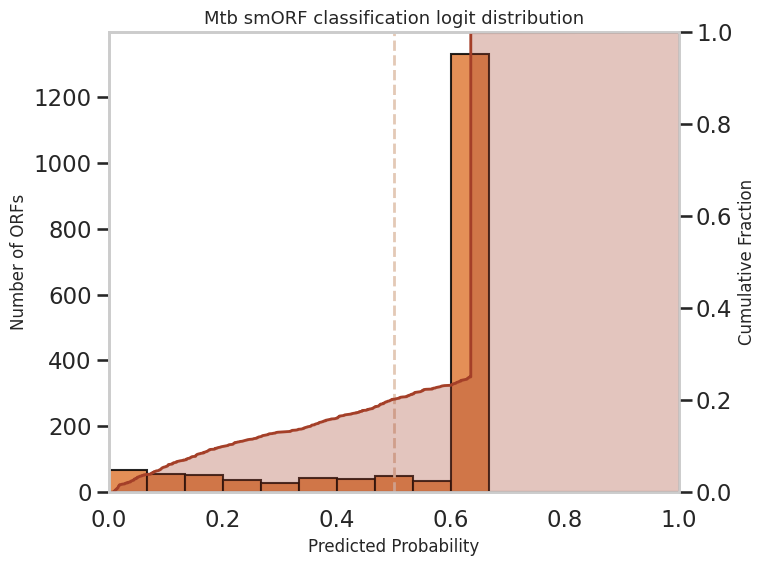

In [ ]:
fig, ax1 = plt.subplots(figsize=(8, 6))

# Define warm colors
hist_color = '#e07b39'        # warm terracotta
cdf_color = '#a43f28'         # warm rust red
threshold_color = '#e3c9b6'   # warm light beige

# Plot histogram
counts, bins, patches = ax1.hist(merged_df['probability'],
                                 bins=15,
                                 range=(0, 1),
                                 color=hist_color,
                                 edgecolor='black',
                                 alpha=0.85)

# Add threshold line
ax1.axvline(x=threshold, color=threshold_color, linestyle='--', linewidth=2)

# Axis labels (default color)
ax1.set_xlabel('Predicted Probability', fontsize=12)
ax1.set_ylabel('Number of ORFs', fontsize=12)

# Axis limits and styling
ax1.set_xlim(0, 1)
ax1.grid(False)

# Prepare CDF (fix endpoint!)
sorted_probs = np.sort(merged_df['probability'])
cumulative = np.linspace(0, 1, len(sorted_probs), endpoint=False)

# Append final point at x = 1.0 and cumulative = 1.0
sorted_probs = np.append(sorted_probs, 1.0)
cumulative = np.append(cumulative, 1.0)

# CDF on secondary axis
ax2 = ax1.twinx()

# Filled CDF
ax2.fill_between(sorted_probs, cumulative, color=cdf_color, alpha=0.3)
# CDF line
ax2.plot(sorted_probs, cumulative, color=cdf_color, linewidth=2)

# Axis labels (default color)
ax2.set_ylabel('Cumulative Fraction', fontsize=12)
ax2.set_ylim(0, 1)
ax2.grid(False)

# REMOVE LEGEND — it's now clean, no legend displayed.

# Title and layout
plt.title('Mtb smORF classification logit distribution', fontsize=13)
plt.tight_layout()

# Optional export
plt.savefig("mtb_smorf_logits.svg", format="svg", bbox_inches='tight')

plt.show()

In [161]:
external_df

orf_id  gene    start      end strand  length  \
0                  Rv0157A   NaN   186495   186623      -     129   
1                  Rv0691A   NaN   791757   791846      +      90   
2                  Rv0749A   NaN   841737   841874      -     138   
3                  Rv1028A  kdpF  1151920  1152012      +      93   
4                  Rv1119c   NaN  1242864  1243013      -     150   
...                    ...   ...      ...      ...    ...     ...   
1730   Ribo_ORF_1084_+_2_5   NaN  4410032  4410085      +      54   
1731   Ribo_ORF_1085_+_2_2   NaN  4410703  4410732      +      30   
1732   Ribo_ORF_1085_-_2_2   NaN  4410738  4410767      -      30   
1733  Ribo_ORF_1085_-_2_14   NaN  4410738  4410755      -      18   
1734  Ribo_ORF_1085_-_2_47   NaN  4410708  4410722      -      15   

                                               sequence      source  \
0     GTGATGGATCCGAGTCCTGACTACGACGTGAGCGACGAAATCGAGT...  Annotation   
1     ATGGACTACGAAACCGATACCGACACCGAGCTTGTCACCGAGACCC...  Annotation   
2     GTGGTGCGCAAACACGCGTTCCACTGGCGCTACGACAGCACCGAGG...  Annotation   
3     ATGACTACGGTCGACAACATCGTCGGGTTGGTGATCGCGGTGGCGC...  Annotation   
4     ATGACCGCTCGGGTTGCGGGGCAAGCGGTCGGCGGCCAGATCCTGG...  Annotation   
...                                                 ...         ...   
1730  ATGAAGTCGAGACTGAAGAAATCAAACAAAAGACTCACGCTCCCCT...    Ribo-seq   
1731                     GTGCTTCACCGTTGTTTCAAAATCCGCTGA    Ribo-seq   
1732                     TTGCGGTGCTTCGTGCACGCAACCGCATGA    Ribo-seq   
1733                                 GTGCACGCAACCGCATGA    Ribo-seq   
1734                                    TTGAAACAACGGTGA    Ribo-seq   

                                         upstream_100bp  \
0     AACTGGTTGTTCAGTTTAGGCAAGGCGGCGACAACCTGTCGCACCG...   
1     CGTGCGGCATCACATTCGCCCTTCCATTTCGGCACTCGATGCCATA...   
2     CCGGAGGCGGCTCCTGAGGTTTGGGGCCGAATCCGATAGCCCGGTA...   
3     GGCTTTGCCTGCTCTACGTCCGTGGCTGTGAACGGATCATTCGCCG...   
4     GCGCAAAGCGTAAGCGGAACCAGGGAATTCGGGTGCGGATCGGCAC...   
...                                                 ...   
1730  GAACATCACCGACAACGCCCAGGCGAAGAAGTTGGATGGTCCTAGC...   
1731  CCGACCCCACCGACTTGGCGATAATCAGTCCGACGCGCGGCCCACC...   
1732  CCGCTTACGGATGCGTACCCGCGCCGGGAGGTCAATTGTGTCCAGC...   
1733  GCGTACCCGCGCCGGGAGGTCAATTGTGTCCAGCCGGCGACGCAAG...   
1734  CCGGCGACGCAAGGGTCGGCGCACGCTCAGTGCTTGATTGCAACAC...   

                                           orf_sequence  \
0     GTGATGGATCCGAGTCCTGACTACGACGTGAGCGACGAAATCGAGT...   
1     ATGGACTACGAAACCGATACCGACACCGAGCTTGTCACCGAGACCC...   
2     GTGGTGCGCAAACACGCGTTCCACTGGCGCTACGACAGCACCGAGG...   
3     ATGACTACGGTCGACAACATCGTCGGGTTGGTGATCGCGGTGGCGC...   
4     ATGACCGCTCGGGTTGCGGGGCAAGCGGTCGGCGGCCAGATCCTGG...   
...                                                 ...   
1730                                                NaN   
1731                                                NaN   
1732                                                NaN   
1733                                                NaN   
1734                                                NaN   

                                       downstream_100bp  \
0     GCCAGCGCTCGCGCGCTACAACGCCTTGAGTTCCTCGGAGACTTCG...   
1     CCGTGCCGGCGCCCGCGCAGGCTCGCCGGGCTGATTCCAGCGAATT...   
2     CTGCTCGAATTGACGCGAGGACGGTGAATCGTCTGGCGCAGCGGTT...   
3     TGTCCGGGACGAGTTGGTTGCAGTTCGCGGCGTTGATCGCGGTGCT...   
4     TAACCGTCGACGTCGGATTCGTCCAGCCTCTGGTGCAATCGGGCCC...   
...                                                 ...   
1730  CGCAGGGTTCCAGTCGTCGTTCGCGCCGTCGACGTCTGTCTGGCAG...   
1731  CCGCCTCATGCGGTTGCGTGCACGAAGCACCGCAAATAAGCCCGGT...   
1732  GGCGGTCAGCGGATTTTGAAACAACGGTGAAGCACGGGATGCGTAC...   
1733  GGCGGTCAGCGGATTTTGAAACAACGGTGAAGCACGGGATGCGTAC...   
1734  AGCACGGGATGCGTACCGTGCGGTCTGACATGGTCGTTTATTGGTG...   

                                        embedding_smorf  \
0     [-0.045898438, -1.078125, -0.048583984, 0.0275...   
1     [-0.03466797, -1.0625, -0.036376953, 0.0279541...   
2     [-0.06640625, -1.09375, -0.0

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


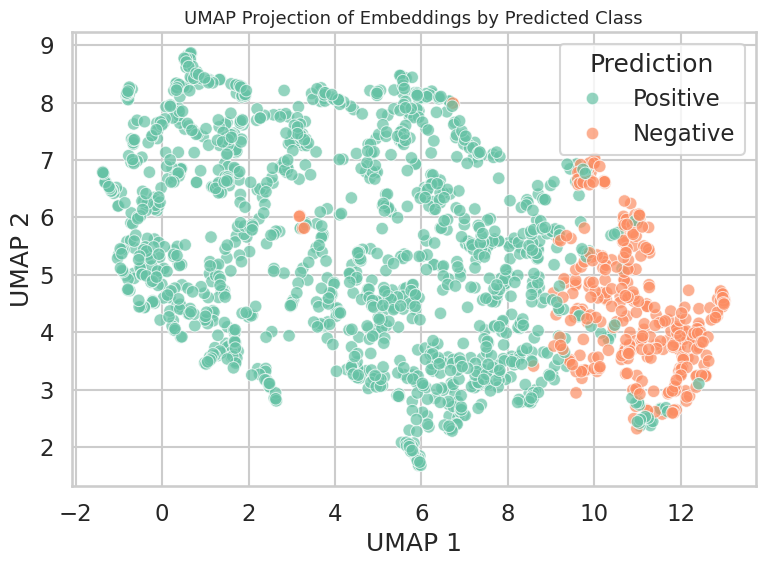

In [165]:
import umap.umap_ as umap
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

external_df["probability"] = results_df['probability']

merged_df = external_df

# Step 2: Prepare embeddings matrix
embedding_series = merged_df['embedding_full']

# Identify valid embeddings (non-NaN)
valid_mask = embedding_series.apply(lambda x: isinstance(x, np.ndarray) and not np.isnan(x).any())

# Filter merged_df to only valid embeddings
clean_df = merged_df[valid_mask].reset_index(drop=True)

# Prepare embeddings matrix
embeddings = np.vstack(clean_df['embedding_full'].values)

# Step 3: Run UMAP
reducer = umap.UMAP(random_state=42)
embedding_umap = reducer.fit_transform(embeddings)

# Step 4: Add UMAP coordinates to DataFrame
merged_df['UMAP1'] = embedding_umap[:, 0]
merged_df['UMAP2'] = embedding_umap[:, 1]

# Step 5: Define prediction label
merged_df['prediction'] = np.where(merged_df['probability'] >= threshold, 'Positive', 'Negative')

# Step 6: Plot UMAP
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='UMAP1', y='UMAP2',
                hue='prediction',
                palette='Set2',
                alpha=0.7)

plt.title('UMAP Projection of Embeddings by Predicted Class', fontsize=13)
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend(title='Prediction', loc='best')
plt.tight_layout()

# Optional export
# plt.savefig("umap_prediction_projection.svg", format="svg", bbox_inches='tight')

plt.show()

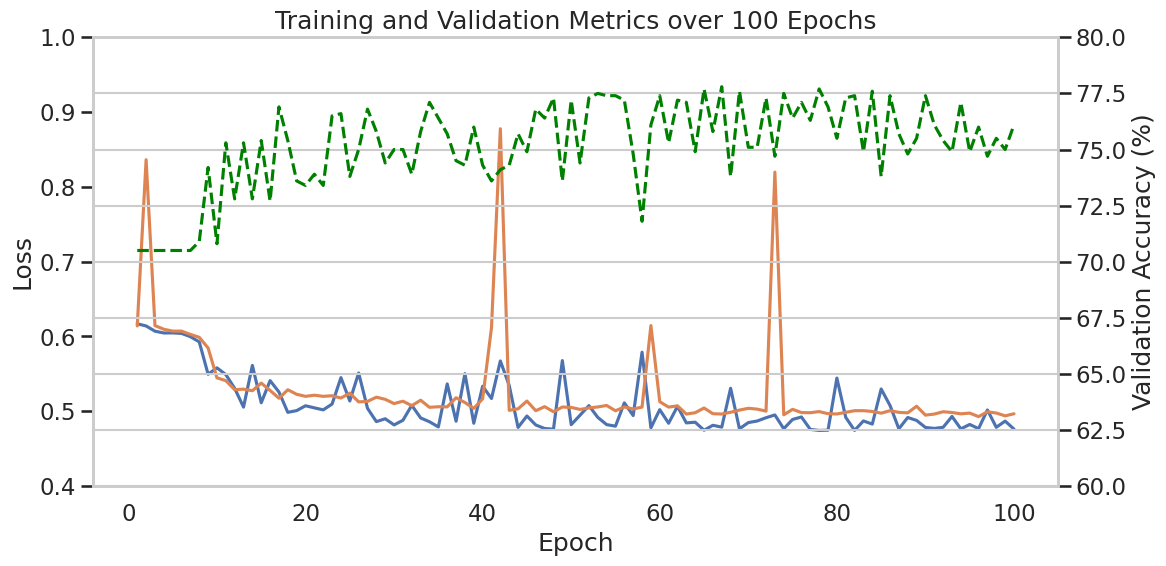

In [157]:
import re

# Let's re-parse the full correct 100-epoch log provided by the user

# Clean up full log text
full_log_text = """
Epoch [1/100] - Train Loss: 0.6141 | Val Loss: 0.6170 | Val Acc: 70.50%
Epoch [2/100] - Train Loss: 0.8364 | Val Loss: 0.6141 | Val Acc: 70.50%
Epoch [3/100] - Train Loss: 0.6146 | Val Loss: 0.6071 | Val Acc: 70.50%
Epoch [4/100] - Train Loss: 0.6097 | Val Loss: 0.6047 | Val Acc: 70.50%
Epoch [5/100] - Train Loss: 0.6072 | Val Loss: 0.6048 | Val Acc: 70.50%
Epoch [6/100] - Train Loss: 0.6072 | Val Loss: 0.6041 | Val Acc: 70.50%
Epoch [7/100] - Train Loss: 0.6028 | Val Loss: 0.5998 | Val Acc: 70.50%
Epoch [8/100] - Train Loss: 0.5989 | Val Loss: 0.5928 | Val Acc: 70.90%
Epoch [9/100] - Train Loss: 0.5846 | Val Loss: 0.5495 | Val Acc: 74.20%
Epoch [10/100] - Train Loss: 0.5447 | Val Loss: 0.5581 | Val Acc: 70.80%
Epoch [11/100] - Train Loss: 0.5410 | Val Loss: 0.5491 | Val Acc: 75.30%
Epoch [12/100] - Train Loss: 0.5289 | Val Loss: 0.5307 | Val Acc: 72.80%
Epoch [13/100] - Train Loss: 0.5296 | Val Loss: 0.5056 | Val Acc: 75.30%
Epoch [14/100] - Train Loss: 0.5275 | Val Loss: 0.5613 | Val Acc: 72.80%
Epoch [15/100] - Train Loss: 0.5377 | Val Loss: 0.5114 | Val Acc: 75.40%
Epoch [16/100] - Train Loss: 0.5279 | Val Loss: 0.5410 | Val Acc: 72.70%
Epoch [17/100] - Train Loss: 0.5174 | Val Loss: 0.5258 | Val Acc: 76.90%
Epoch [18/100] - Train Loss: 0.5288 | Val Loss: 0.4986 | Val Acc: 75.40%
Epoch [19/100] - Train Loss: 0.5227 | Val Loss: 0.5009 | Val Acc: 73.60%
Epoch [20/100] - Train Loss: 0.5200 | Val Loss: 0.5074 | Val Acc: 73.40%
Epoch [21/100] - Train Loss: 0.5215 | Val Loss: 0.5046 | Val Acc: 73.90%
Epoch [22/100] - Train Loss: 0.5200 | Val Loss: 0.5019 | Val Acc: 73.40%
Epoch [23/100] - Train Loss: 0.5208 | Val Loss: 0.5097 | Val Acc: 76.50%
Epoch [24/100] - Train Loss: 0.5177 | Val Loss: 0.5450 | Val Acc: 76.60%
Epoch [25/100] - Train Loss: 0.5243 | Val Loss: 0.5138 | Val Acc: 73.80%
Epoch [26/100] - Train Loss: 0.5126 | Val Loss: 0.5512 | Val Acc: 75.00%
Epoch [27/100] - Train Loss: 0.5132 | Val Loss: 0.5040 | Val Acc: 76.80%
Epoch [28/100] - Train Loss: 0.5189 | Val Loss: 0.4862 | Val Acc: 75.80%
Epoch [29/100] - Train Loss: 0.5160 | Val Loss: 0.4900 | Val Acc: 74.40%
Epoch [30/100] - Train Loss: 0.5103 | Val Loss: 0.4818 | Val Acc: 75.00%
Epoch [31/100] - Train Loss: 0.5135 | Val Loss: 0.4880 | Val Acc: 75.00%
Epoch [32/100] - Train Loss: 0.5075 | Val Loss: 0.5080 | Val Acc: 73.90%
Epoch [33/100] - Train Loss: 0.5148 | Val Loss: 0.4911 | Val Acc: 75.80%
Epoch [34/100] - Train Loss: 0.5053 | Val Loss: 0.4860 | Val Acc: 77.10%
Epoch [35/100] - Train Loss: 0.5061 | Val Loss: 0.4791 | Val Acc: 76.40%
Epoch [36/100] - Train Loss: 0.5059 | Val Loss: 0.5366 | Val Acc: 75.70%
Epoch [37/100] - Train Loss: 0.5181 | Val Loss: 0.4867 | Val Acc: 74.50%
Epoch [38/100] - Train Loss: 0.5117 | Val Loss: 0.5504 | Val Acc: 74.30%
Epoch [39/100] - Train Loss: 0.5039 | Val Loss: 0.4840 | Val Acc: 76.00%
Epoch [40/100] - Train Loss: 0.5167 | Val Loss: 0.5335 | Val Acc: 74.30%
Epoch [41/100] - Train Loss: 0.6119 | Val Loss: 0.5171 | Val Acc: 73.60%
Epoch [42/100] - Train Loss: 0.8778 | Val Loss: 0.5673 | Val Acc: 74.10%
Epoch [43/100] - Train Loss: 0.5013 | Val Loss: 0.5345 | Val Acc: 74.30%
Epoch [44/100] - Train Loss: 0.5033 | Val Loss: 0.4784 | Val Acc: 75.70%
Epoch [45/100] - Train Loss: 0.5137 | Val Loss: 0.4937 | Val Acc: 74.90%
Epoch [46/100] - Train Loss: 0.5008 | Val Loss: 0.4817 | Val Acc: 76.80%
Epoch [47/100] - Train Loss: 0.5062 | Val Loss: 0.4770 | Val Acc: 76.40%
Epoch [48/100] - Train Loss: 0.4994 | Val Loss: 0.4761 | Val Acc: 77.30%
Epoch [49/100] - Train Loss: 0.5057 | Val Loss: 0.5678 | Val Acc: 73.60%
Epoch [50/100] - Train Loss: 0.5052 | Val Loss: 0.4821 | Val Acc: 77.20%
Epoch [51/100] - Train Loss: 0.5025 | Val Loss: 0.4948 | Val Acc: 74.40%
Epoch [52/100] - Train Loss: 0.5045 | Val Loss: 0.5076 | Val Acc: 77.30%
Epoch [53/100] - Train Loss: 0.5058 | Val Loss: 0.4919 | Val Acc: 77.50%
Epoch [54/100] - Train Loss: 0.5078 | Val Loss: 0.4822 | Val Acc: 77.40%
Epoch [55/100] - Train Loss: 0.5007 | Val Loss: 0.4801 | Val Acc: 77.40%
Epoch [56/100] - Train Loss: 0.5058 | Val Loss: 0.5113 | Val Acc: 77.20%
Epoch [57/100] - Train Loss: 0.5031 | Val Loss: 0.4943 | Val Acc: 74.80%
Epoch [58/100] - Train Loss: 0.5056 | Val Loss: 0.5790 | Val Acc: 71.80%
Epoch [59/100] - Train Loss: 0.6146 | Val Loss: 0.4779 | Val Acc: 76.10%
Epoch [60/100] - Train Loss: 0.5128 | Val Loss: 0.5022 | Val Acc: 77.40%
Epoch [61/100] - Train Loss: 0.5056 | Val Loss: 0.4840 | Val Acc: 75.30%
Epoch [62/100] - Train Loss: 0.5073 | Val Loss: 0.5066 | Val Acc: 77.20%
Epoch [63/100] - Train Loss: 0.4963 | Val Loss: 0.4845 | Val Acc: 77.10%
Epoch [64/100] - Train Loss: 0.4981 | Val Loss: 0.4854 | Val Acc: 74.90%
Epoch [65/100] - Train Loss: 0.5044 | Val Loss: 0.4747 | Val Acc: 77.70%
Epoch [66/100] - Train Loss: 0.4968 | Val Loss: 0.4813 | Val Acc: 75.80%
Epoch [67/100] - Train Loss: 0.4963 | Val Loss: 0.4788 | Val Acc: 77.80%
Epoch [68/100] - Train Loss: 0.4987 | Val Loss: 0.5308 | Val Acc: 73.80%
Epoch [69/100] - Train Loss: 0.5016 | Val Loss: 0.4766 | Val Acc: 77.60%
Epoch [70/100] - Train Loss: 0.5040 | Val Loss: 0.4849 | Val Acc: 75.10%
Epoch [71/100] - Train Loss: 0.5029 | Val Loss: 0.4870 | Val Acc: 75.10%
Epoch [72/100] - Train Loss: 0.5002 | Val Loss: 0.4914 | Val Acc: 77.30%
Epoch [73/100] - Train Loss: 0.8198 | Val Loss: 0.4951 | Val Acc: 74.70%
Epoch [74/100] - Train Loss: 0.4953 | Val Loss: 0.4767 | Val Acc: 77.50%
Epoch [75/100] - Train Loss: 0.5026 | Val Loss: 0.4891 | Val Acc: 76.40%
Epoch [76/100] - Train Loss: 0.4983 | Val Loss: 0.4924 | Val Acc: 77.10%
Epoch [77/100] - Train Loss: 0.4981 | Val Loss: 0.4758 | Val Acc: 76.30%
Epoch [78/100] - Train Loss: 0.4996 | Val Loss: 0.4744 | Val Acc: 77.70%
Epoch [79/100] - Train Loss: 0.4968 | Val Loss: 0.4747 | Val Acc: 76.90%
Epoch [80/100] - Train Loss: 0.4964 | Val Loss: 0.5444 | Val Acc: 75.50%
Epoch [81/100] - Train Loss: 0.4986 | Val Loss: 0.4919 | Val Acc: 77.30%
Epoch [82/100] - Train Loss: 0.5008 | Val Loss: 0.4745 | Val Acc: 77.40%
Epoch [83/100] - Train Loss: 0.5008 | Val Loss: 0.4871 | Val Acc: 74.90%
Epoch [84/100] - Train Loss: 0.4998 | Val Loss: 0.4829 | Val Acc: 77.60%
Epoch [85/100] - Train Loss: 0.4975 | Val Loss: 0.5298 | Val Acc: 73.80%
Epoch [86/100] - Train Loss: 0.5008 | Val Loss: 0.5078 | Val Acc: 77.40%
Epoch [87/100] - Train Loss: 0.4986 | Val Loss: 0.4766 | Val Acc: 75.70%
Epoch [88/100] - Train Loss: 0.4979 | Val Loss: 0.4917 | Val Acc: 74.80%
Epoch [89/100] - Train Loss: 0.5068 | Val Loss: 0.4878 | Val Acc: 75.50%
Epoch [90/100] - Train Loss: 0.4949 | Val Loss: 0.4784 | Val Acc: 77.40%
Epoch [91/100] - Train Loss: 0.4963 | Val Loss: 0.4771 | Val Acc: 76.10%
Epoch [92/100] - Train Loss: 0.4994 | Val Loss: 0.4786 | Val Acc: 75.40%
Epoch [93/100] - Train Loss: 0.4984 | Val Loss: 0.4931 | Val Acc: 74.90%
Epoch [94/100] - Train Loss: 0.4966 | Val Loss: 0.4765 | Val Acc: 77.10%
Epoch [95/100] - Train Loss: 0.4976 | Val Loss: 0.4824 | Val Acc: 74.90%
Epoch [96/100] - Train Loss: 0.4929 | Val Loss: 0.4768 | Val Acc: 76.00%
Epoch [97/100] - Train Loss: 0.4993 | Val Loss: 0.5018 | Val Acc: 74.70%
Epoch [98/100] - Train Loss: 0.4977 | Val Loss: 0.4786 | Val Acc: 75.50%
Epoch [99/100] - Train Loss: 0.4939 | Val Loss: 0.4869 | Val Acc: 75.00%
Epoch [100/100] - Train Loss: 0.4967 | Val Loss: 0.4762 | Val Acc: 76.10%
"""

# Use the actual full text provided by the user
full_log_text = full_log_text.strip().split('\n')

# Lists to collect data
epochs, train_losses, val_losses, val_accs = [], [], [], []

# Regex pattern to extract data
pattern = r"Epoch \[(\d+)/\d+\] - Train Loss: ([\d.]+) \| Val Loss: ([\d.]+) \| Val Acc: ([\d.]+)%"

# Parse each line
for line in full_log_text:
    match = re.match(pattern, line)
    if match:
        epochs.append(int(match.group(1)))
        train_losses.append(float(match.group(2)))
        val_losses.append(float(match.group(3)))
        val_accs.append(float(match.group(4)))

# Build DataFrame
df_clean = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': train_losses,
    'Validation Loss': val_losses,
    'Validation Accuracy': val_accs
})

# Plot with all 100 data points
plt.figure(figsize=(12, 6))

# Train Loss and Validation Loss
plt.plot(df_clean['Epoch'], df_clean['Validation Loss'], label='Validation Loss', linestyle='-')
plt.plot(df_clean['Epoch'], df_clean['Train Loss'], label='Train Loss', marker='', linestyle='-')

# Validation Accuracy (secondary axis)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(df_clean['Epoch'], df_clean['Validation Accuracy'], label='Validation Accuracy', color='green', linestyle='--')

# Labels and title
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_ylim(0.4, 1)
ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_ylim(60, 80)
plt.title('Training and Validation Metrics over 100 Epochs')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

# Explicitly remove grid from both axes
ax1.grid(False)
# Show plot
plt.tight_layout()
plt.show()